## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from datetime import datetime

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

import seaborn as sns
import pandas as pd

import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## ⏳ Load

In [2]:
# Load the dataset
print("Loading Mars dataset...")
data = np.load("/kaggle/input/mars-training-set/mars_for_students.npz")
training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]
X_test = data["test_set"]

# Add a channel
X_train_val = X_train[..., np.newaxis]
y_train_val = y_train[..., np.newaxis]
X_test = X_test[..., np.newaxis] 
X_test = X_test / 255.0

print("Dataset loaded!")

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train_val))

print(f"\nInput shape: {input_shape}")
print(f"Number of classes: {num_classes}")

print(f"\nShape of X_train: {X_train_val.shape}")
print(f"Shape of y_train: {y_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")

Loading Mars dataset...
Dataset loaded!

Input shape: (64, 128)
Number of classes: 5

Shape of X_train: (2615, 64, 128, 1)
Shape of y_train: (2615, 64, 128, 1)
Shape of X_test: (10022, 64, 128, 1)


## 👽 Detect Outliers

In [3]:
import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

#def create_segmentation_colormap(num_classes):
 #   return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap):
    
    # Ensure label is 2D
    label = np.squeeze(label)

    # Ensure label values are in the valid range [0, num_classes-1]
    num_classes = len(colormap)  # Get the number of classes from the colormap
    label = np.clip(label, 0, num_classes - 1)  # Clip values to be within range

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

# Define the colormap (manually specifying colors for each class)
colormap = np.array([
    [0, 0, 0],        # black for background
    [139, 69, 19],    # brown for soil
    [80, 80, 80],  # gray for bedrock
    [244, 164, 96],   # sandy brown for sand
    [105, 105, 105]   # dark gray for big rock
]) / 255.0  # Normalize to [0, 1] range for matplotlib

# Function to calculate the hash of an image
def calculate_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Calculate hashes for each image and store their indices
def calculate_hash(y_train_val):
    hash_dict = defaultdict(list)
    for idx, image in enumerate(y_train_val):
        img_hash = calculate_image_hash(image)
        hash_dict[img_hash].append(idx)
    return hash_dict

def calculate_duplicates(y_train_val):

    # Find duplicates
    hash_dict = calculate_hash(y_train_val)
    return {key: indices for key, indices in hash_dict.items() if len(indices) > 1}

def plot_duplicates(y_train_val):
    
    duplicates = calculate_duplicates(y_train_val)

    if duplicates:
        print("Duplicate images found!")
   
        num_duplicates = len(duplicates)
        cols = 5 
        rows = (num_duplicates + cols - 1) // cols  
    
        # Create the figure and subplots
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        axes = axes.flatten()

        # Create colormap for labels
        num_classes = len(np.unique(y_train_val))
       # colormap = create_segmentation_colormap(num_classes)

        for i, (img_hash, indices) in enumerate(duplicates.items()):
            # Select one representative image
            representative_idx = indices[0]
            occurrence_count = len(indices)  
            ax = axes[i]

            colored_label = apply_colormap(y_train_val[representative_idx], colormap)
            ax.imshow(colored_label)

            # Set title with hash, occurrences, and first index
            ax.set_title(f"Idx: {representative_idx}, Count: {occurrence_count}")
            ax.axis('off')

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')
        
        plt.tight_layout()
        plt.show()

    else:
        print("No duplicate images found!")   

# Function to get images associated with a specific index
def get_images_by_index(index):
    hash_dict = calculate_hash(y_train_val)
    img_hash = calculate_image_hash(y_train_val[index])  # Calculate hash
    associated_indices = hash_dict.get(img_hash, [])  # Get duplicate indices
    return img_hash, associated_indices



In [4]:
alien_index = 62

# Get associated indices
img_hash, alin_associated_indices = get_images_by_index(alien_index)

if(X_train_val.shape[0] == 2615):
    X_train_val = np.delete(X_train_val, alin_associated_indices, axis=0)
    y_train_val = np.delete(y_train_val, alin_associated_indices, axis=0)
    print("Outliers removed")
else:
    print("Outliers already removed")

print("Dataset dimension:", X_train_val.shape)

Outliers removed
Dataset dimension: (2505, 64, 128, 1)


## 🔄 Process Data

In [5]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 35

# Set maximum number of training epochs
EPOCHS = 250

# Set data split size for training and validation
SPLITS_SIZE = 0.2

In [6]:
# Split the training set into training and validation sets
print("Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

# Display dataset information
print(f"\nNumber of images:")
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")

Splitting data...
Data splitted!

Number of images:
Training set: 2004
Validation set: 501
Test set: 10022


In [7]:
# Define the category mapping
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4   # big rock
}

# Define the classes 
classes = ['background', 'soil', 'bedrock', 'sand', 'big rock'] 

NUM_CLASSES = len(set(category_map.values()))
print(f"Number of categories: {len(category_map)}")

Number of categories: 5


In [8]:
# Define augmentation
def random_flip_left_right(image, label, seed):
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

def random_flip_up_down(image, label, seed):
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob < 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob < 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    return image, label

def random_rot90(image, label, seed):
    """Random 90-degree rotations."""
    k = tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32) *2
    image = tf.image.rot90(image, k)
    label = tf.image.rot90(label, k)
    return image, label

def random_contrast(image, label, seed):
    flip_prob = tf.random.uniform([], seed=seed)
    contrast_factor = tf.random.uniform([], 2, 2.5)
    image = tf.cond(
        flip_prob < 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    image = tf.image.adjust_contrast(image, contrast_factor)
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    #image = image[0,:,:,:]
    return image, label

def apply_augmentations(image, label):
    seed = np.random.randint(0, 1000000)
    image, label = random_flip_left_right(image, label, seed)
    #image, label = random_flip_up_down(image, label, seed)
    #image, label = random_contrast(image, label, seed)
    return image, label

In [9]:
def preprocess_data(X, y, input_size=(64, 128)):
    X = tf.image.resize(X, input_size)
    X = tf.cast(X, tf.float32) / 255.0
    
    y = tf.image.resize(y, input_size, method='bilinear')
    y = tf.cast(y, tf.int32)
    return X, y

In [10]:
def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a TensorFlow dataset. 
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) #create data from images and masks

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed) #we can shuffle it

    # Preprocess immages and labels
    dataset = dataset.map(
        preprocess_data,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply augmentations if specified
    if augment:
        dataset = dataset.map(
            lambda x, y: apply_augmentations(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )


    # Batch the data (do it now and not at training time)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [11]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False #for validation not necessary to shuffle it
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


## 🛠️ Model Definition and Training

In [12]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')  # first block with 32 filters
    d1 = tfkl.MaxPooling2D()(down_block_1)  # reduce spatial complexity

    down_block_2 = unet_block(d1, 64, name='down_block2_')  # second block with 64 filters
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')  # third block with 128 filters
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 256, name='down_block4_')  # added block with 256 filters
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck with 512 filters
    bottleneck = unet_block(d4, filters=512, name='bottleneck_aspp')

    # Upsampling path: increase spatial complexity
    u1 = tfkl.UpSampling2D()(bottleneck)  # Upsampling layer

    u1 = tfkl.Concatenate()([u1, down_block_4, d3, tfkl.MaxPooling2D()(d2), tfkl.MaxPooling2D()(tfkl.MaxPooling2D()(d1))])  # Skip connection from downsampling path
    u1 = unet_block(u1, 256, name='up_block1_')  # first upsampling block with 256 filters

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_3, d2, tfkl.MaxPooling2D()(d1), tfkl.UpSampling2D()(down_block_4)])
    u2 = unet_block(u2, 128, name='up_block2_')  # second upsampling block with 128 filters

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2, d1, tfkl.UpSampling2D()(down_block_3), tfkl.UpSampling2D()(tfkl.UpSampling2D()(down_block_4))  ])
    u3 = unet_block(u3, 64, name='up_block3_')  # third upsampling block with 64 filters

    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1, tfkl.UpSampling2D()(down_block_2), tfkl.UpSampling2D()(tfkl.UpSampling2D()(down_block_3)), tfkl.UpSampling2D()(tfkl.UpSampling2D()(tfkl.UpSampling2D()(down_block_4)))])
    u4 = unet_block(u4, 32, name='up_block4_')  # fourth upsampling block with 32 filters

    # Output Layer: final convolution with softmax activation for segmentation
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_conv1 │ (None, 16, 32,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_bn1   │ (None, 16, 32,  │       512 │ down_block3_c… │   Y 

 Total params: 9,148,229 (34.90 MB)

 Trainable params: 9,142,341 (34.88 MB)

 Non-trainable params: 5,888 (23.00 KB)

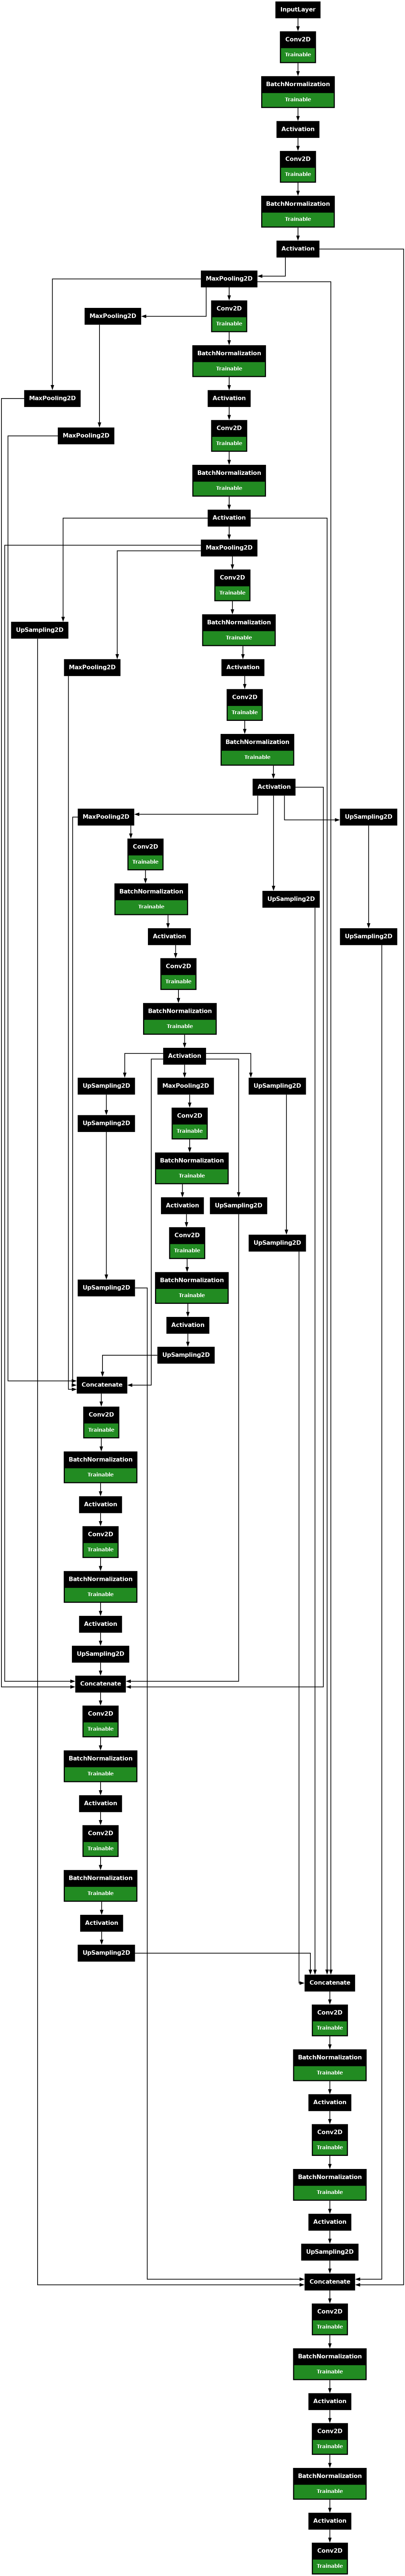

In [13]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=False, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=False, dpi=70)

In [14]:
def load_single_image(image_path, label_path, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)  # Force 1 channel for grayscale
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float32) / 255.0   # Normalize to [0, 1]

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='nearest')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label


In [15]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback: plot during the training the prediction and the images
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, frequency=5):
        super().__init__()
        self.val_dataset = val_dataset  # The validation dataset
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Get a batch from the validation dataset
            for image_batch, label_batch in self.val_dataset.take(1):
                image = image_batch[3]  # Take the first image from the batch
                label = label_batch[3]  # Take the first label from the batch

                # Add batch dimension to the image (if necessary)
                image = tf.expand_dims(image, 0)

                # Perform prediction
                pred = self.model.predict(image, verbose=0)
                y_pred = tf.math.argmax(pred, axis=-1)
                y_pred = y_pred.numpy()  # Convert to NumPy array for visualization

                # Create colormap (assuming a predefined function `create_segmentation_colormap`)
                num_classes = NUM_CLASSES
               # colormap = create_segmentation_colormap(num_classes)

                # Plot the results
                plt.figure(figsize=(16, 4))

                # Input image
                plt.subplot(1, 3, 1)
                plt.imshow(image[0], cmap='gray')
                plt.title("Input Image")
                plt.axis('off')

                # Ground truth
                plt.subplot(1, 3, 2)
                colored_label = apply_colormap(label.numpy(), colormap)  # Assuming `apply_colormap` is defined
                plt.imshow(colored_label)
                plt.title("Ground Truth Mask")
                plt.axis('off')

                # Prediction
                plt.subplot(1, 3, 3)
                colored_pred = apply_colormap(y_pred[0], colormap)  # Apply colormap to prediction
                plt.imshow(colored_pred)
                plt.title("Predicted Mask")
                plt.axis('off')

                plt.tight_layout()
                plt.show()
                plt.close()


In [16]:
y_train_flatt = y_train.flatten()

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flatt),
    y=y_train_flatt
)

class_weights[0] = 0 # adjusting class weight
class_weights[4] = 10
class_weights = dict(enumerate(class_weights)) 
print("Class weights:", class_weights)

Class weights: {0: 0.0, 1: 0.5935027933021484, 2: 0.8366099618482732, 3: 1.1096943312319119, 4: 10.0}


In [17]:

class BoundaryLoss(tf.keras.losses.Loss):
    def __init__(self, idc, **kwargs):
        """
        Boundary Loss implementation in TensorFlow.
        Args:
            idc (List[int]): List of class indices to filter out in the target mask.
        """
        super().__init__(**kwargs)
        self.idc = idc  # Classes to exclude
        #print(f"Initialized {self.__class__.__name__} with idc={idc}")

    def call(self, probs, dist_maps):
        """
        Compute the boundary loss.
        Args:
            probs (tf.Tensor): Predicted probabilities, shape (batch_size, num_classes, height, width).
            dist_maps (tf.Tensor): Distance maps, shape (batch_size, num_classes, height, width).
        
        Returns:
            tf.Tensor: Scalar loss value.
        """
        # Ensure the inputs are valid
        tf.debugging.assert_less_equal(tf.reduce_max(probs), 1.0, "Probs are not simplex (values > 1)")
        tf.debugging.assert_greater_equal(tf.reduce_min(probs), 0.0, "Probs are not simplex (values < 0)")

        # Exclude the specified classes
        all_classes = tf.range(probs.shape[1])  # All class indices
        include_classes = tf.boolean_mask(all_classes, ~tf.reduce_any(all_classes[..., None] == self.idc, axis=-1))

        # Select only the included classes
        pc = tf.gather(probs, include_classes, axis=1)
        dc = tf.gather(dist_maps, include_classes, axis=1)

        # Perform element-wise multiplication
        multiplied = tf.multiply(pc, dc)

        # Compute mean loss
        loss = multiplied

        return tf.reduce_mean(loss)

In [18]:
def dice_loss_with_excluded_classes(y_true, y_pred, excluded_classes=[]):
    """
    Compute the Dice loss, excluding specific classes from the evaluation.

    Parameters:
    - y_true: Tensor of shape (batch_size, ..., num_classes), ground truth one-hot labels.
    - y_pred: Tensor of shape (batch_size, ..., num_classes), predicted probabilities.
    - excluded_classes: List of class indices to exclude from the loss computation.

    Returns:
    - Dice loss value, averaged over the included classes.
    """
    # Convert excluded_classes to a Tensor for proper indexing
    excluded_classes = tf.constant(excluded_classes, dtype=tf.int32)

    # Ensure y_pred values are between 0 and 1
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

    # Compute numerator (intersection) and denominator for Dice coefficient
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])  # Summing over spatial dimensions
    denominator = tf.reduce_sum(y_true + y_pred, axis=[0, 1, 2])  # Summing over spatial dimensions

    # Avoid division by zero
    dice_coeff = numerator / (denominator + 1e-7)

    # Create a mask to exclude specified classes
    mask = tf.ones_like(dice_coeff, dtype=tf.bool)
    mask = tf.tensor_scatter_nd_update(mask, tf.expand_dims(excluded_classes, axis=-1), tf.zeros_like(excluded_classes, dtype=tf.bool))

    # Apply mask to exclude classes
    included_dice_coeff = tf.boolean_mask(dice_coeff, mask)

    # Compute Dice loss as 1 - mean Dice coefficient of included classes
    dice_loss = 1 - tf.reduce_mean(included_dice_coeff)

    return dice_loss

In [19]:
excluded_classes = [0]
SCCE = tf.keras.losses.SparseCategoricalCrossentropy()
Boundary = BoundaryLoss(idc=excluded_classes)

'''
adjusts the weights based on the epoch number, 
reducing the Focal loss weight and increasing the Dice loss weight as training progresses.
'''

class DynamicLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super(DynamicLoss, self).__init__(**kwargs)
        self.initial_dice_weight = 0.4
        self.initial_scce_weight = 0.4
        self.initial_boundary_weight = 0.2
        
        self.scce_weight = self.initial_scce_weight
        self.dice_weight = self.initial_dice_weight
        self.boundary_weight = self.initial_boundary_weight

    def update_weights(self, epoch):
        total_epochs = EPOCHS
        epoch_factor = epoch / total_epochs
        
        # Adjust weights dynamically
        self.scce_weight = self.initial_scce_weight + epoch_factor * (1 - self.initial_scce_weight)
        self.dice_weight = self.initial_dice_weight - epoch_factor * self.initial_dice_weight
        self.boundary_weight = self.initial_boundary_weight + epoch_factor * (1 - self.initial_boundary_weight)
        
        # Normalize weights so they sum to 1
        total_weight = self.scce_weight +  self.dice_weight + self.boundary_weight
        self.scce_weight /= total_weight
        self.dice_weight /= total_weight
        self.boundary_weight /= total_weight

        print(f"SCCE weight: {self.scce_weight:.4f} - "
              f"dice weight: {self.dice_weight:.4f} - "
              f"boundary weight: {self.boundary_weight:.4f}")

    def call(self, y_true, y_pred):

        y_true = tf.cast(y_true, tf.int32)  # Make sure y_true is of type int32
        y_true = tf.squeeze(y_true, axis=-1)  # Remove any extra dimensions (like [batch_size, height, width, 1])
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])  # Convert to one-hot encoding
        y_true = tf.cast(y_true, tf.float32)
        
        # evaluating weights based on classes pixel by pixel, normalized
        class_weights_tensor = tf.constant([class_weights[key] for key in sorted(class_weights.keys())], dtype=tf.float32)

        sample_weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)

        # Calculate individual losses
        y_true_indices = tf.argmax(y_true, axis=-1) # sparse categorical cross entropy expect a y_true with y_prede_dim-1
        SCCE_value = SCCE(y_true_indices, y_pred, sample_weight=sample_weights)
        
        Dice_value = dice_loss_with_excluded_classes(y_true, y_pred, excluded_classes)
        Boundary_value = Boundary(y_true, y_pred)

        # Combine losses
        total_loss = self.scce_weight * SCCE_value + self.dice_weight * Dice_value + self.boundary_weight * Boundary_value
        return tf.reduce_mean(total_loss)

In [20]:
class EpochTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EpochTracker, self).__init__()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch 
        self.model.loss.update_weights(epoch)
        
    def get_epoch(self):
        return getattr(self, 'epoch', 0) 

In [21]:
# Compile the model
dynamic_loss = DynamicLoss()
# keep track of the epochs for the dynamic_loss updates
epoch_tracker = EpochTracker()

model.compile(
    loss=dynamic_loss, 
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

In [22]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

learning_rate = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=40, 
    min_delta=1e-6
)

viz_callback = VizCallback(val_dataset, frequency=5)

SCCE weight: 0.4000 - dice weight: 0.4000 - boundary weight: 0.2000
Epoch 1/250


I0000 00:00:1734099596.455435      70 service.cc:145] XLA service 0x792b98015b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734099596.455514      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734099596.455523      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1734099602.559700      70 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734099602.562258      70 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1734099602.564827      70 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert
I0000 00:00:1734099646.691146      70 device_compiler.h:188] Comp

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.3865 - loss: 0.5755 - mean_iou: 0.2201

W0000 00:00:1734099658.505373      71 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734099658.506916      71 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1734099658.508428      71 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3887 - loss: 0.5738 - mean_iou: 0.2216   

W0000 00:00:1734099688.906504      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734099688.910390      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1734099688.914454      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert
W0000 00:00:1734099695.461547      71 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734099695.463082      71 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1734099695.464512      71 assert_op.cc:38] Ignoring Assert operator compile_loss/dynami

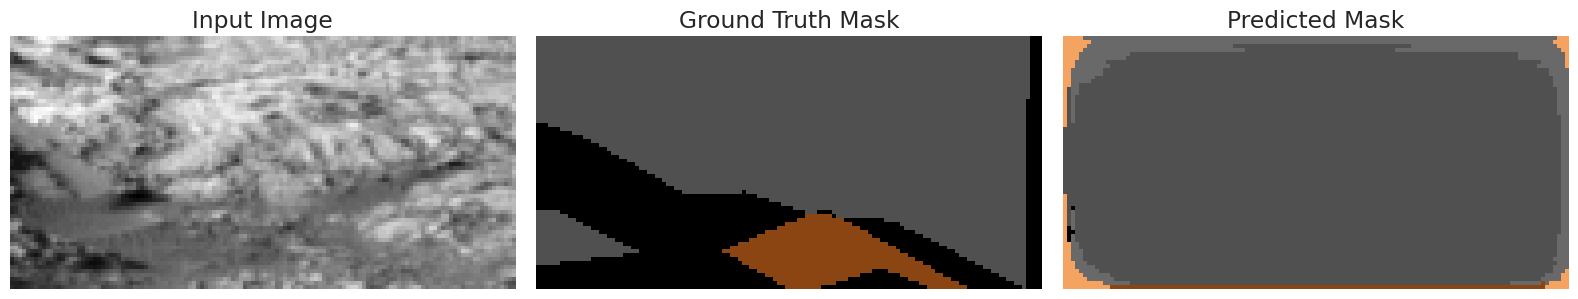

32/32 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.3908 - loss: 0.5721 - mean_iou: 0.2230 - val_accuracy: 0.1909 - val_loss: 3.2636 - val_mean_iou: 0.0590 - learning_rate: 0.0010
SCCE weight: 0.4008 - dice weight: 0.3968 - boundary weight: 0.2024
Epoch 2/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 360ms/step - accuracy: 0.5205 - loss: 0.4539 - mean_iou: 0.4090 - val_accuracy: 0.1979 - val_loss: 1.1260 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4016 - dice weight: 0.3937 - boundary weight: 0.2048
Epoch 3/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 371ms/step - accuracy: 0.5391 - loss: 0.4266 - mean_iou: 0.4410 - val_accuracy: 0.1979 - val_loss: 1.4993 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4024 - dice weight: 0.3905 - boundary weight: 0.2071
Epoch 4/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 390ms/step - accuracy: 0.5576 - loss: 0.4127 - mean_iou: 0.4607 - val_accuracy: 0.1979 - val_loss: 1.2020 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4031 - dice

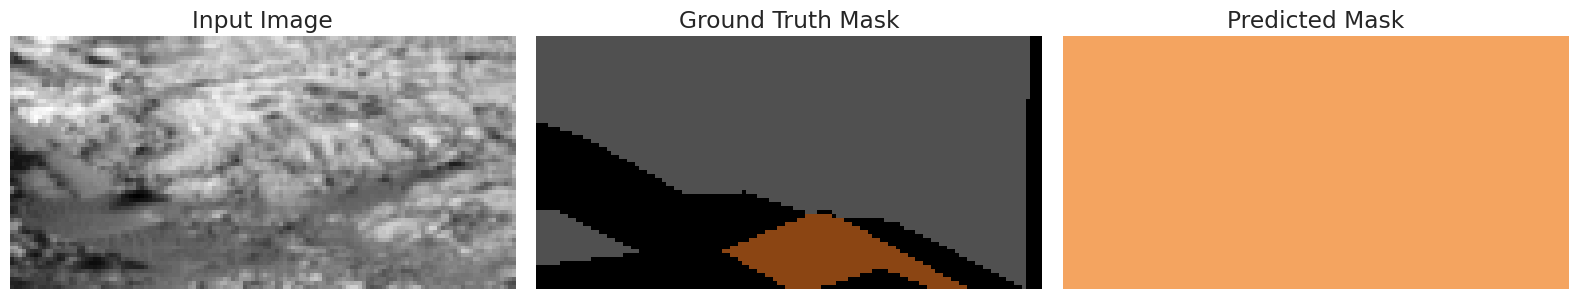

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.5930 - loss: 0.3692 - mean_iou: 0.5136 - val_accuracy: 0.1979 - val_loss: 1.7028 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4047 - dice weight: 0.3813 - boundary weight: 0.2141
Epoch 7/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.5946 - loss: 0.3729 - mean_iou: 0.5191 - val_accuracy: 0.1979 - val_loss: 1.8510 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4054 - dice weight: 0.3782 - boundary weight: 0.2163
Epoch 8/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step - accuracy: 0.6180 - loss: 0.3480 - mean_iou: 0.5448 - val_accuracy: 0.1979 - val_loss: 1.5051 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4062 - dice weight: 0.3752 - boundary weight: 0.2186
Epoch 9/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 383ms/step - accuracy: 0.6152 - loss: 0.3408 - mean_iou: 0.5451 - val_accuracy: 0.1979 - val_loss: 1.7184 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4069 - di

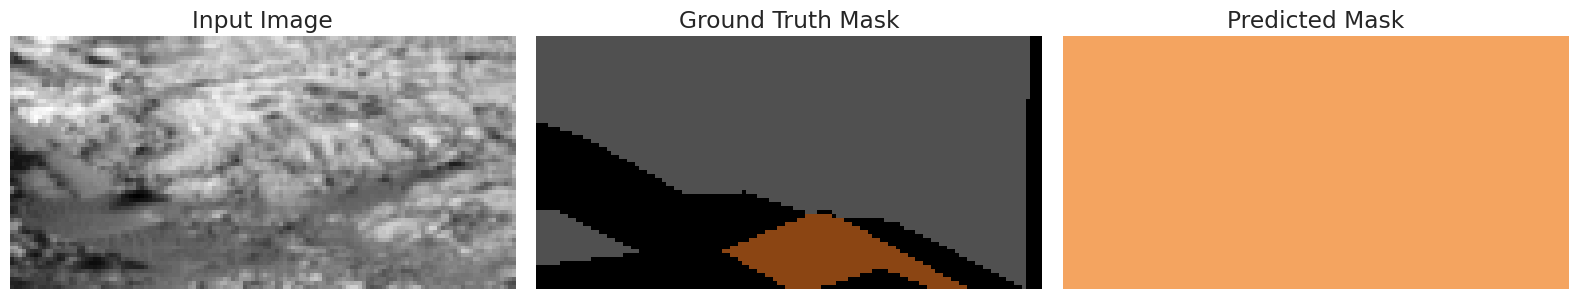

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - accuracy: 0.6185 - loss: 0.3368 - mean_iou: 0.5499 - val_accuracy: 0.1979 - val_loss: 1.3871 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4084 - dice weight: 0.3663 - boundary weight: 0.2253
Epoch 12/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.6263 - loss: 0.3341 - mean_iou: 0.5651 - val_accuracy: 0.1979 - val_loss: 1.3771 - val_mean_iou: 0.0657 - learning_rate: 0.0010
SCCE weight: 0.4092 - dice weight: 0.3634 - boundary weight: 0.2275
Epoch 13/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - accuracy: 0.6433 - loss: 0.3098 - mean_iou: 0.5945 - val_accuracy: 0.2163 - val_loss: 1.2432 - val_mean_iou: 0.0805 - learning_rate: 0.0010
SCCE weight: 0.4099 - dice weight: 0.3605 - boundary weight: 0.2297
Epoch 14/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.6439 - loss: 0.3092 - mean_iou: 0.5895 - val_accuracy: 0.2115 - val_loss: 1.3182 - val_mean_iou: 0.0766 - learning_rate: 0.0010
SCCE weight: 0.4106 -

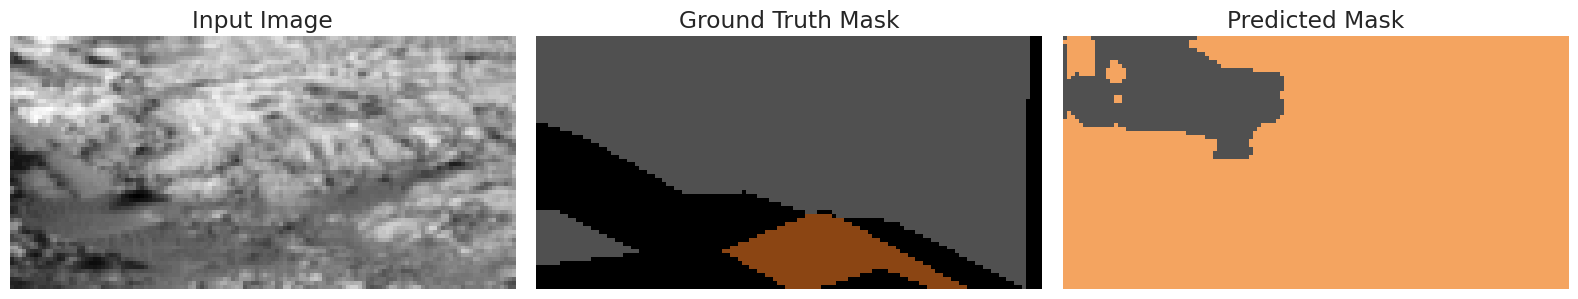

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 418ms/step - accuracy: 0.6419 - loss: 0.3123 - mean_iou: 0.5974 - val_accuracy: 0.3158 - val_loss: 0.9180 - val_mean_iou: 0.1766 - learning_rate: 0.0010
SCCE weight: 0.4120 - dice weight: 0.3519 - boundary weight: 0.2361
Epoch 17/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 389ms/step - accuracy: 0.6443 - loss: 0.3062 - mean_iou: 0.5955 - val_accuracy: 0.4104 - val_loss: 0.6939 - val_mean_iou: 0.2718 - learning_rate: 0.0010
SCCE weight: 0.4127 - dice weight: 0.3491 - boundary weight: 0.2382
Epoch 18/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.6544 - loss: 0.2988 - mean_iou: 0.6202 - val_accuracy: 0.5006 - val_loss: 0.5587 - val_mean_iou: 0.3843 - learning_rate: 0.0010
SCCE weight: 0.4134 - dice weight: 0.3463 - boundary weight: 0.2403
Epoch 19/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.6582 - loss: 0.2897 - mean_iou: 0.6192 - val_accuracy: 0.5014 - val_loss: 0.5810 - val_mean_iou: 0.3910 - learning_rate: 0.0010
SCCE weight: 0.4141 -

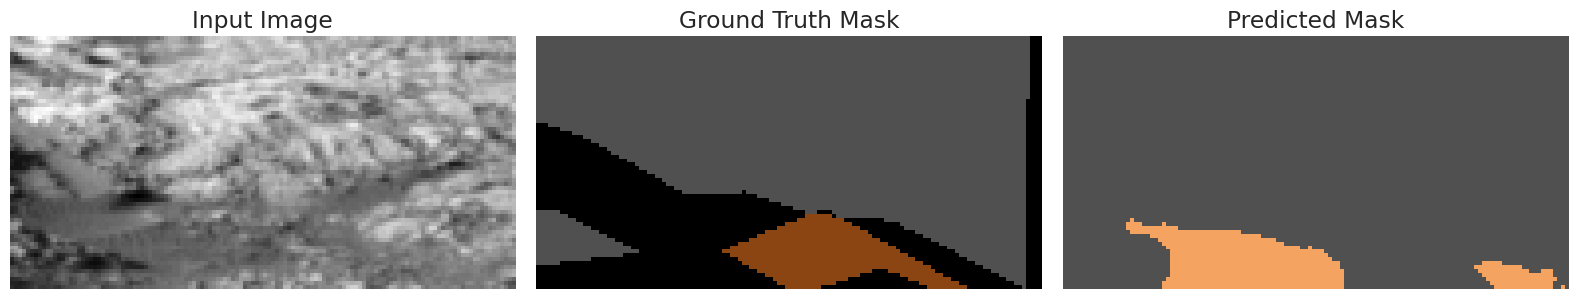

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 415ms/step - accuracy: 0.6508 - loss: 0.2964 - mean_iou: 0.6160 - val_accuracy: 0.3396 - val_loss: 0.9532 - val_mean_iou: 0.2163 - learning_rate: 0.0010
SCCE weight: 0.4155 - dice weight: 0.3380 - boundary weight: 0.2465
Epoch 22/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.6563 - loss: 0.2949 - mean_iou: 0.6107 - val_accuracy: 0.3762 - val_loss: 0.7856 - val_mean_iou: 0.2761 - learning_rate: 0.0010
SCCE weight: 0.4162 - dice weight: 0.3353 - boundary weight: 0.2485
Epoch 23/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.6682 - loss: 0.2781 - mean_iou: 0.6387 - val_accuracy: 0.4253 - val_loss: 0.6826 - val_mean_iou: 0.3326 - learning_rate: 0.0010
SCCE weight: 0.4168 - dice weight: 0.3326 - boundary weight: 0.2505
Epoch 24/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.6675 - loss: 0.2778 - mean_iou: 0.6557 - val_accuracy: 0.5175 - val_loss: 0.5381 - val_mean_iou: 0.4000 - learning_rate: 0.0010
SCCE weight: 0.4175 -

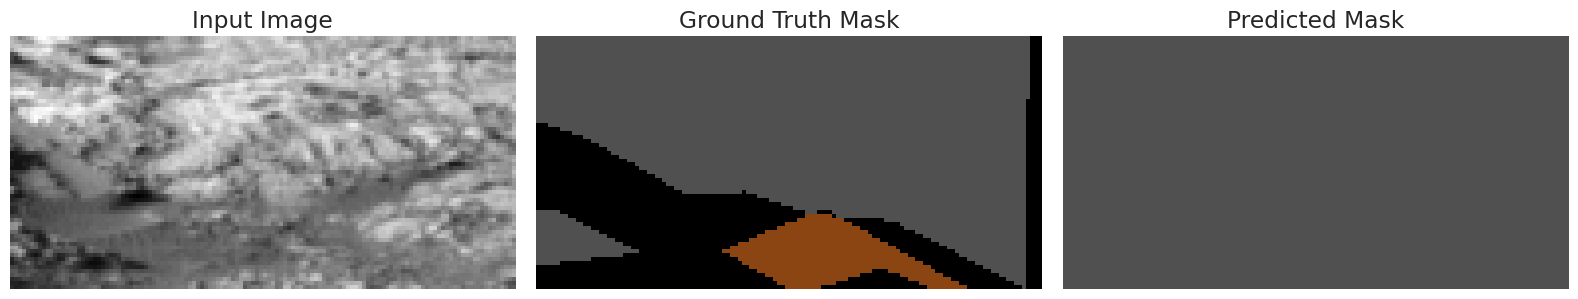

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.6689 - loss: 0.2733 - mean_iou: 0.6552 - val_accuracy: 0.5474 - val_loss: 0.4390 - val_mean_iou: 0.4867 - learning_rate: 0.0010
SCCE weight: 0.4188 - dice weight: 0.3246 - boundary weight: 0.2565
Epoch 27/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 390ms/step - accuracy: 0.6732 - loss: 0.2682 - mean_iou: 0.6727 - val_accuracy: 0.5409 - val_loss: 0.4761 - val_mean_iou: 0.4761 - learning_rate: 0.0010
SCCE weight: 0.4195 - dice weight: 0.3220 - boundary weight: 0.2585
Epoch 28/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 391ms/step - accuracy: 0.6674 - loss: 0.2763 - mean_iou: 0.6343 - val_accuracy: 0.3993 - val_loss: 0.6516 - val_mean_iou: 0.2901 - learning_rate: 0.0010
SCCE weight: 0.4201 - dice weight: 0.3194 - boundary weight: 0.2604
Epoch 29/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.6732 - loss: 0.2696 - mean_iou: 0.6481 - val_accuracy: 0.6327 - val_loss: 0.3416 - val_mean_iou: 0.5726 - learning_rate: 0.0010
SCCE weight: 0.4208 -

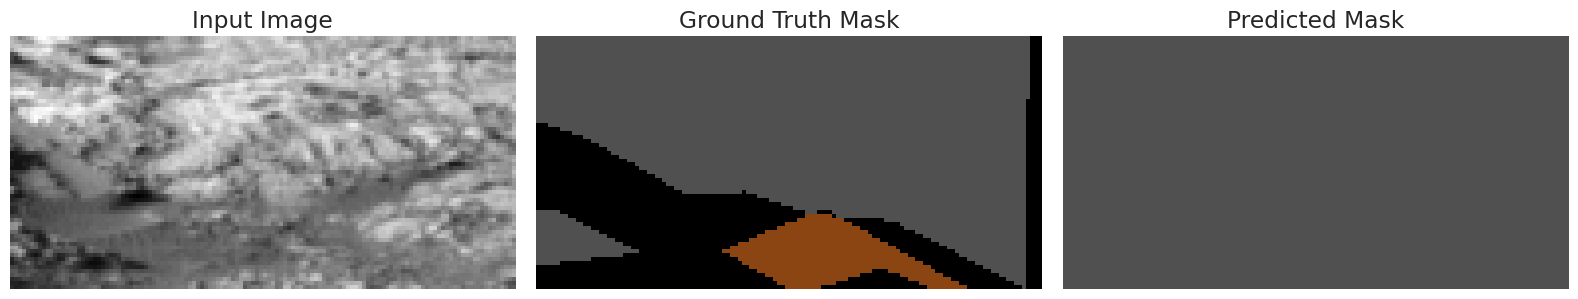

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.6718 - loss: 0.2653 - mean_iou: 0.6870 - val_accuracy: 0.5918 - val_loss: 0.4698 - val_mean_iou: 0.5259 - learning_rate: 0.0010
SCCE weight: 0.4221 - dice weight: 0.3117 - boundary weight: 0.2662
Epoch 32/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.6795 - loss: 0.2537 - mean_iou: 0.7037 - val_accuracy: 0.6239 - val_loss: 0.3544 - val_mean_iou: 0.5747 - learning_rate: 0.0010
SCCE weight: 0.4227 - dice weight: 0.3092 - boundary weight: 0.2681
Epoch 33/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.6761 - loss: 0.2635 - mean_iou: 0.6558 - val_accuracy: 0.5464 - val_loss: 0.5539 - val_mean_iou: 0.4234 - learning_rate: 0.0010
SCCE weight: 0.4233 - dice weight: 0.3067 - boundary weight: 0.2700
Epoch 34/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.6784 - loss: 0.2644 - mean_iou: 0.6862 - val_accuracy: 0.5826 - val_loss: 0.4349 - val_mean_iou: 0.4982 - learning_rate: 0.0010
SCCE weight: 0.4239 -

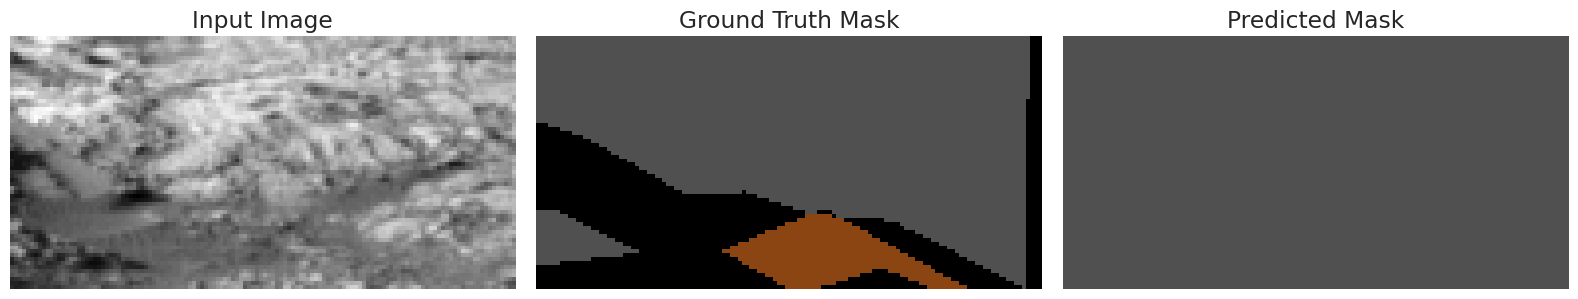

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 414ms/step - accuracy: 0.6858 - loss: 0.2497 - mean_iou: 0.7063 - val_accuracy: 0.6100 - val_loss: 0.3679 - val_mean_iou: 0.5419 - learning_rate: 0.0010
SCCE weight: 0.4252 - dice weight: 0.2993 - boundary weight: 0.2755
Epoch 37/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.6758 - loss: 0.2712 - mean_iou: 0.6506 - val_accuracy: 0.5383 - val_loss: 0.5754 - val_mean_iou: 0.4542 - learning_rate: 0.0010
SCCE weight: 0.4258 - dice weight: 0.2969 - boundary weight: 0.2774
Epoch 38/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.6873 - loss: 0.2483 - mean_iou: 0.7257 - val_accuracy: 0.5951 - val_loss: 0.4297 - val_mean_iou: 0.5208 - learning_rate: 0.0010
SCCE weight: 0.4264 - dice weight: 0.2944 - boundary weight: 0.2792
Epoch 39/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - accuracy: 0.6812 - loss: 0.2494 - mean_iou: 0.7313 - val_accuracy: 0.5980 - val_loss: 0.4508 - val_mean_iou: 0.4990 - learning_rate: 0.0010
SCCE weight: 0.4270 -

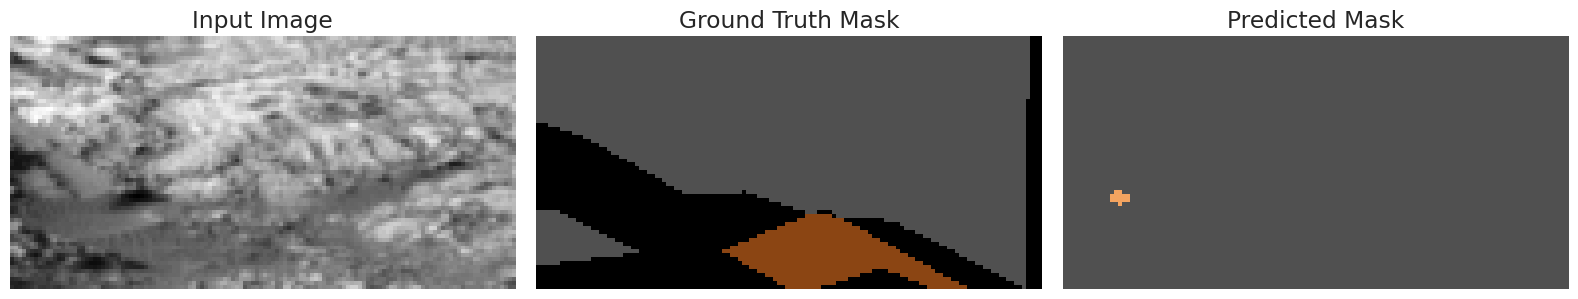

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 414ms/step - accuracy: 0.6857 - loss: 0.2503 - mean_iou: 0.7071 - val_accuracy: 0.5707 - val_loss: 0.3943 - val_mean_iou: 0.5098 - learning_rate: 0.0010
SCCE weight: 0.4282 - dice weight: 0.2873 - boundary weight: 0.2845
Epoch 42/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.6817 - loss: 0.2448 - mean_iou: 0.7378 - val_accuracy: 0.6038 - val_loss: 0.3845 - val_mean_iou: 0.5165 - learning_rate: 0.0010
SCCE weight: 0.4288 - dice weight: 0.2849 - boundary weight: 0.2863
Epoch 43/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.6841 - loss: 0.2367 - mean_iou: 0.7476 - val_accuracy: 0.6263 - val_loss: 0.3736 - val_mean_iou: 0.5322 - learning_rate: 0.0010
SCCE weight: 0.4294 - dice weight: 0.2826 - boundary weight: 0.2881
Epoch 44/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.6894 - loss: 0.2307 - mean_iou: 0.7747 - val_accuracy: 0.5073 - val_loss: 0.5533 - val_mean_iou: 0.3757 - learning_rate: 0.0010
SCCE weight: 0.4299 -

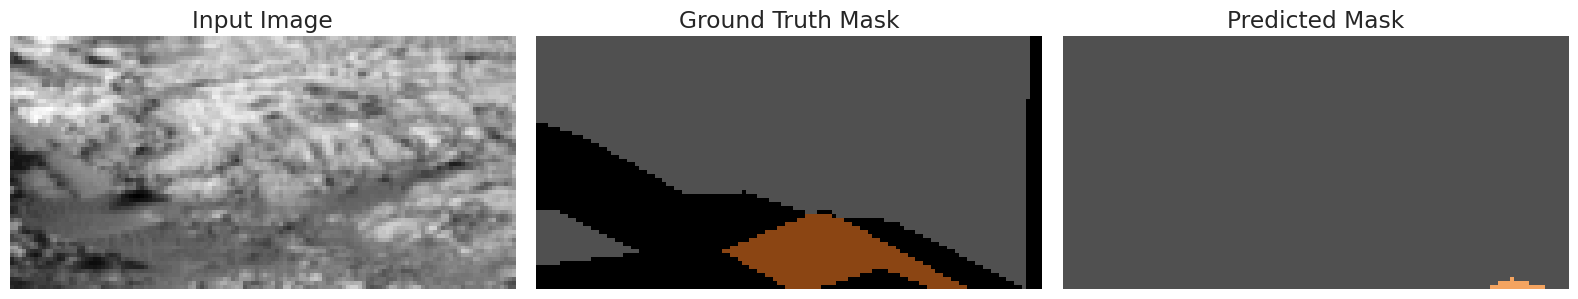

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - accuracy: 0.6756 - loss: 0.2613 - mean_iou: 0.6955 - val_accuracy: 0.4099 - val_loss: 0.6636 - val_mean_iou: 0.3237 - learning_rate: 0.0010
SCCE weight: 0.4311 - dice weight: 0.2757 - boundary weight: 0.2932
Epoch 47/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.6902 - loss: 0.2373 - mean_iou: 0.7343 - val_accuracy: 0.6457 - val_loss: 0.3453 - val_mean_iou: 0.5797 - learning_rate: 0.0010
SCCE weight: 0.4316 - dice weight: 0.2734 - boundary weight: 0.2949
Epoch 48/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - accuracy: 0.6889 - loss: 0.2236 - mean_iou: 0.8163 - val_accuracy: 0.6127 - val_loss: 0.3974 - val_mean_iou: 0.5063 - learning_rate: 0.0010
SCCE weight: 0.4322 - dice weight: 0.2711 - boundary weight: 0.2966
Epoch 49/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.6921 - loss: 0.2288 - mean_iou: 0.7797 - val_accuracy: 0.5808 - val_loss: 0.4095 - val_mean_iou: 0.5046 - learning_rate: 0.0010
SCCE weight: 0.4328 -

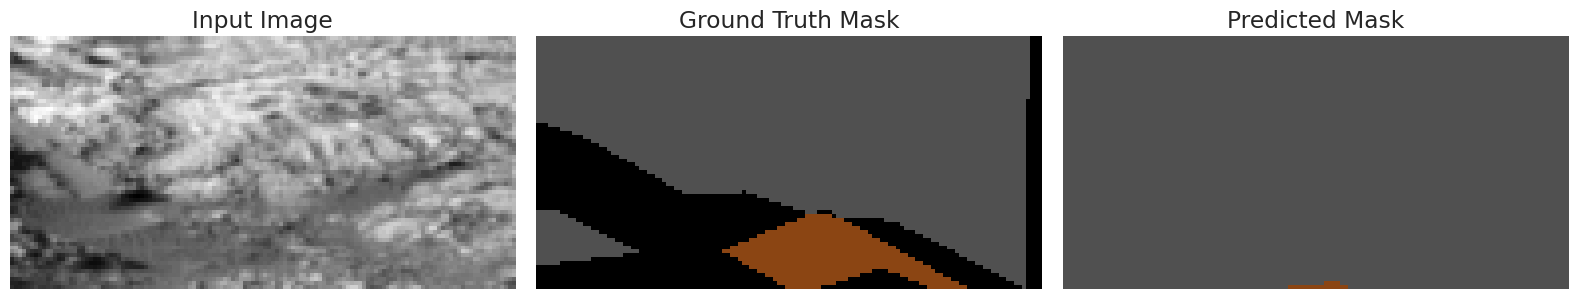

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 412ms/step - accuracy: 0.6814 - loss: 0.2430 - mean_iou: 0.7102 - val_accuracy: 0.6420 - val_loss: 0.3764 - val_mean_iou: 0.5640 - learning_rate: 0.0010
SCCE weight: 0.4339 - dice weight: 0.2645 - boundary weight: 0.3017
Epoch 52/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 391ms/step - accuracy: 0.6866 - loss: 0.2335 - mean_iou: 0.7508 - val_accuracy: 0.6172 - val_loss: 0.4366 - val_mean_iou: 0.5106 - learning_rate: 0.0010
SCCE weight: 0.4344 - dice weight: 0.2623 - boundary weight: 0.3033
Epoch 53/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.6924 - loss: 0.2206 - mean_iou: 0.7963 - val_accuracy: 0.6230 - val_loss: 0.3560 - val_mean_iou: 0.5584 - learning_rate: 0.0010
SCCE weight: 0.4350 - dice weight: 0.2601 - boundary weight: 0.3050
Epoch 54/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.6997 - loss: 0.2175 - mean_iou: 0.8065 - val_accuracy: 0.6076 - val_loss: 0.3887 - val_mean_iou: 0.5595 - learning_rate: 0.0010
SCCE weight: 0.4355 -

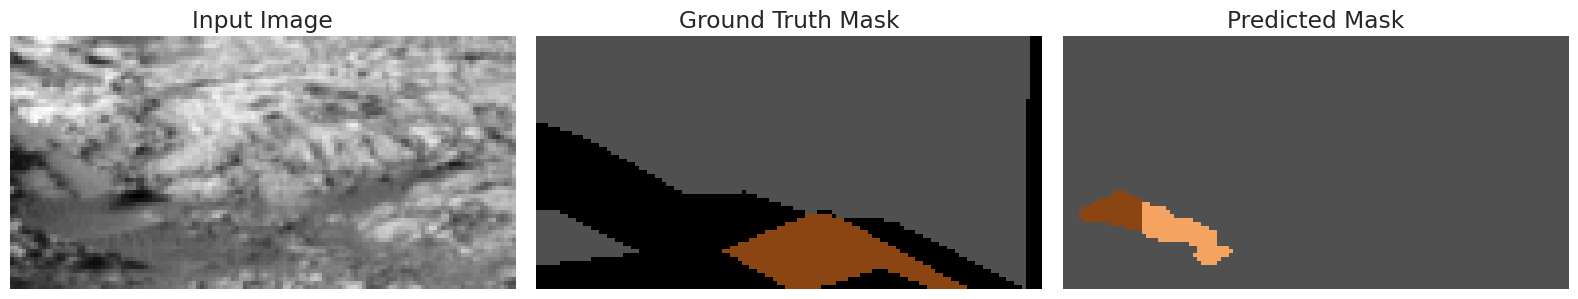

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 408ms/step - accuracy: 0.6954 - loss: 0.2235 - mean_iou: 0.7569 - val_accuracy: 0.5798 - val_loss: 0.4483 - val_mean_iou: 0.4797 - learning_rate: 0.0010
SCCE weight: 0.4366 - dice weight: 0.2536 - boundary weight: 0.3098
Epoch 57/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 391ms/step - accuracy: 0.6859 - loss: 0.2449 - mean_iou: 0.6983 - val_accuracy: 0.6202 - val_loss: 0.4502 - val_mean_iou: 0.5321 - learning_rate: 0.0010
SCCE weight: 0.4371 - dice weight: 0.2515 - boundary weight: 0.3114
Epoch 58/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.6994 - loss: 0.2103 - mean_iou: 0.8021 - val_accuracy: 0.6418 - val_loss: 0.3481 - val_mean_iou: 0.5918 - learning_rate: 0.0010
SCCE weight: 0.4377 - dice weight: 0.2494 - boundary weight: 0.3130
Epoch 59/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.6929 - loss: 0.2252 - mean_iou: 0.7475 - val_accuracy: 0.5315 - val_loss: 0.5645 - val_mean_iou: 0.3996 - learning_rate: 0.0010
SCCE weight: 0.4382 -

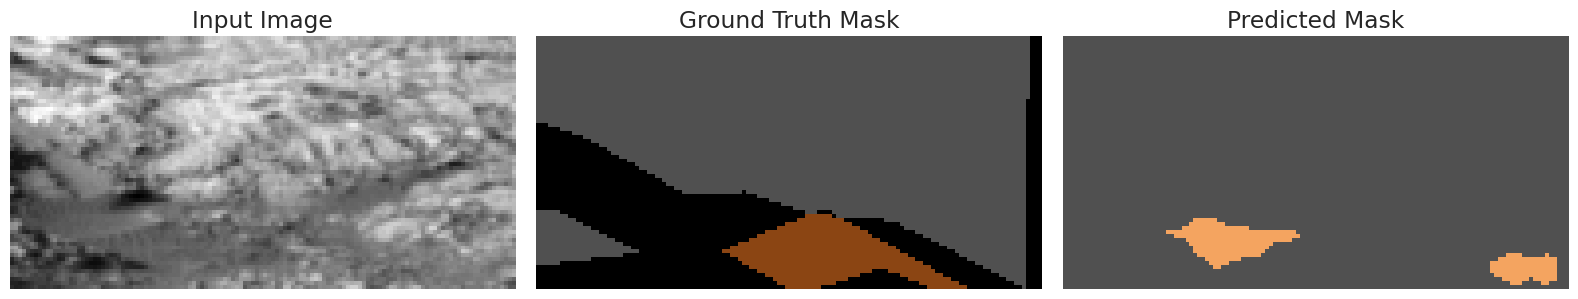

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - accuracy: 0.7024 - loss: 0.2098 - mean_iou: 0.8521 - val_accuracy: 0.6503 - val_loss: 0.3282 - val_mean_iou: 0.6245 - learning_rate: 0.0010
SCCE weight: 0.4392 - dice weight: 0.2431 - boundary weight: 0.3177
Epoch 62/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.7035 - loss: 0.1900 - mean_iou: 0.8600 - val_accuracy: 0.6450 - val_loss: 0.3449 - val_mean_iou: 0.6118 - learning_rate: 0.0010
SCCE weight: 0.4397 - dice weight: 0.2410 - boundary weight: 0.3192
Epoch 63/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.7040 - loss: 0.1945 - mean_iou: 0.8568 - val_accuracy: 0.6280 - val_loss: 0.3953 - val_mean_iou: 0.5273 - learning_rate: 0.0010
SCCE weight: 0.4403 - dice weight: 0.2390 - boundary weight: 0.3208
Epoch 64/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7100 - loss: 0.1929 - mean_iou: 0.8800 - val_accuracy: 0.6221 - val_loss: 0.4099 - val_mean_iou: 0.5184 - learning_rate: 0.0010
SCCE weight: 0.4408 -

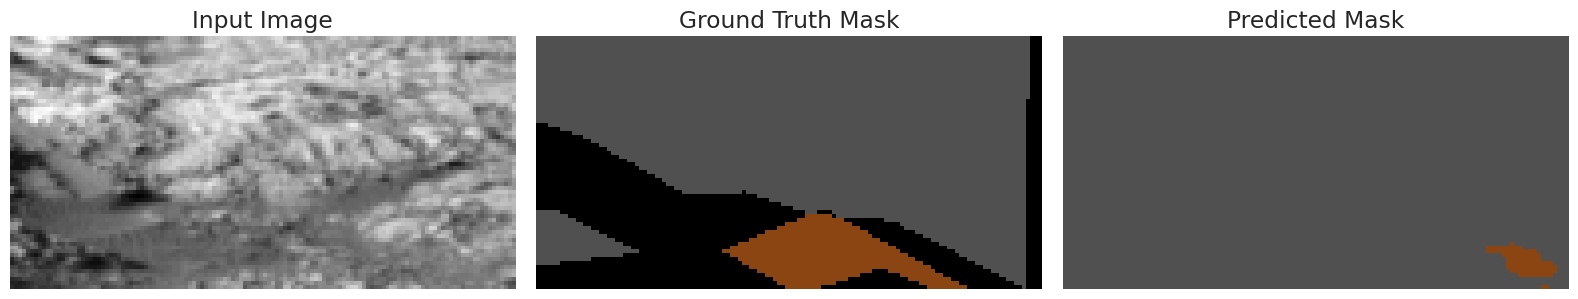

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - accuracy: 0.7080 - loss: 0.1876 - mean_iou: 0.8631 - val_accuracy: 0.6384 - val_loss: 0.3708 - val_mean_iou: 0.5608 - learning_rate: 0.0010
SCCE weight: 0.4418 - dice weight: 0.2329 - boundary weight: 0.3253
Epoch 67/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7120 - loss: 0.1817 - mean_iou: 0.8852 - val_accuracy: 0.6456 - val_loss: 0.3591 - val_mean_iou: 0.5597 - learning_rate: 0.0010
SCCE weight: 0.4423 - dice weight: 0.2309 - boundary weight: 0.3268
Epoch 68/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7086 - loss: 0.1858 - mean_iou: 0.8824 - val_accuracy: 0.6414 - val_loss: 0.3521 - val_mean_iou: 0.6000 - learning_rate: 0.0010
SCCE weight: 0.4428 - dice weight: 0.2289 - boundary weight: 0.3283
Epoch 69/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7107 - loss: 0.1872 - mean_iou: 0.8843 - val_accuracy: 0.6535 - val_loss: 0.3573 - val_mean_iou: 0.5856 - learning_rate: 0.0010
SCCE weight: 0.4433 -

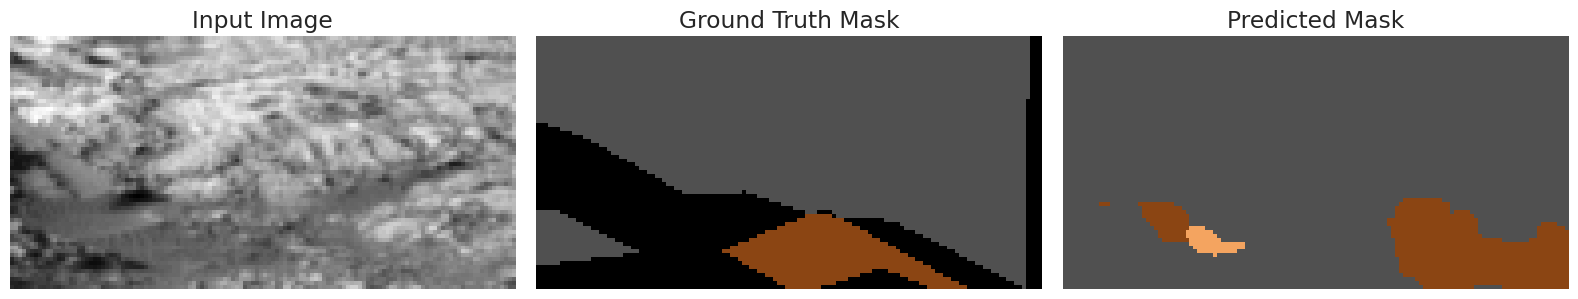

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - accuracy: 0.7162 - loss: 0.1747 - mean_iou: 0.8839 - val_accuracy: 0.6383 - val_loss: 0.3916 - val_mean_iou: 0.5545 - learning_rate: 0.0010
SCCE weight: 0.4442 - dice weight: 0.2231 - boundary weight: 0.3327
Epoch 72/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7052 - loss: 0.1894 - mean_iou: 0.8589 - val_accuracy: 0.6541 - val_loss: 0.3709 - val_mean_iou: 0.5698 - learning_rate: 0.0010
SCCE weight: 0.4447 - dice weight: 0.2211 - boundary weight: 0.3342
Epoch 73/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7078 - loss: 0.1975 - mean_iou: 0.8473 - val_accuracy: 0.5761 - val_loss: 0.4947 - val_mean_iou: 0.4636 - learning_rate: 0.0010
SCCE weight: 0.4452 - dice weight: 0.2192 - boundary weight: 0.3356
Epoch 74/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.7111 - loss: 0.1816 - mean_iou: 0.8754 - val_accuracy: 0.6456 - val_loss: 0.3702 - val_mean_iou: 0.5731 - learning_rate: 0.0010
SCCE weight: 0.4457 -

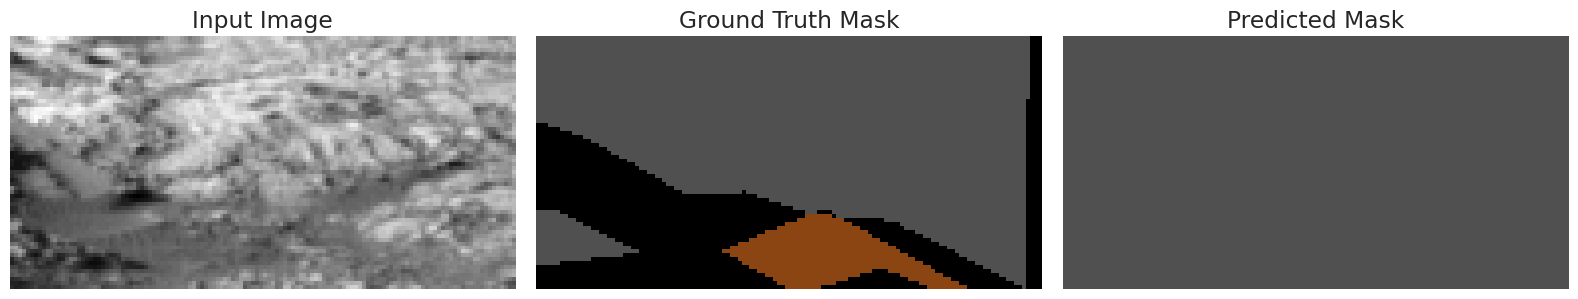

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 416ms/step - accuracy: 0.7146 - loss: 0.1830 - mean_iou: 0.8920 - val_accuracy: 0.6601 - val_loss: 0.3437 - val_mean_iou: 0.6380 - learning_rate: 0.0010
SCCE weight: 0.4466 - dice weight: 0.2135 - boundary weight: 0.3399
Epoch 77/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.7151 - loss: 0.1726 - mean_iou: 0.9007 - val_accuracy: 0.6764 - val_loss: 0.3230 - val_mean_iou: 0.6407 - learning_rate: 0.0010
SCCE weight: 0.4471 - dice weight: 0.2116 - boundary weight: 0.3413
Epoch 78/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.7170 - loss: 0.1609 - mean_iou: 0.8999 - val_accuracy: 0.6591 - val_loss: 0.3493 - val_mean_iou: 0.5762 - learning_rate: 0.0010
SCCE weight: 0.4476 - dice weight: 0.2098 - boundary weight: 0.3427
Epoch 79/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.7208 - loss: 0.1854 - mean_iou: 0.8757 - val_accuracy: 0.6644 - val_loss: 0.3551 - val_mean_iou: 0.5847 - learning_rate: 0.0010
SCCE weight: 0.4480 -

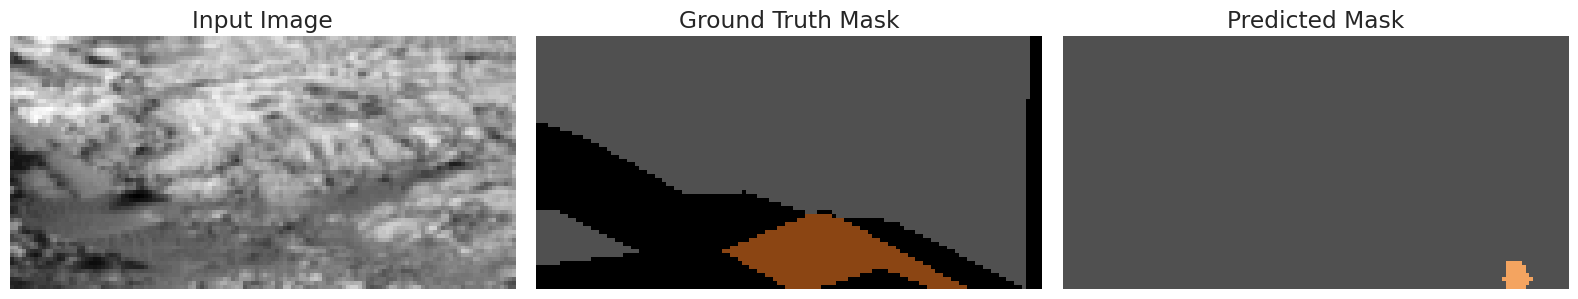

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 415ms/step - accuracy: 0.7043 - loss: 0.1960 - mean_iou: 0.8128 - val_accuracy: 0.6300 - val_loss: 0.3735 - val_mean_iou: 0.5764 - learning_rate: 0.0010
SCCE weight: 0.4489 - dice weight: 0.2042 - boundary weight: 0.3468
Epoch 82/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - accuracy: 0.7155 - loss: 0.1768 - mean_iou: 0.8828 - val_accuracy: 0.6321 - val_loss: 0.3767 - val_mean_iou: 0.5900 - learning_rate: 0.0010
SCCE weight: 0.4494 - dice weight: 0.2024 - boundary weight: 0.3482
Epoch 83/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.7139 - loss: 0.1795 - mean_iou: 0.8776 - val_accuracy: 0.5170 - val_loss: 0.5218 - val_mean_iou: 0.4049 - learning_rate: 0.0010
SCCE weight: 0.4498 - dice weight: 0.2006 - boundary weight: 0.3495
Epoch 84/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.7158 - loss: 0.1746 - mean_iou: 0.9049 - val_accuracy: 0.6238 - val_loss: 0.4172 - val_mean_iou: 0.5282 - learning_rate: 0.0010
SCCE weight: 0.4503 -

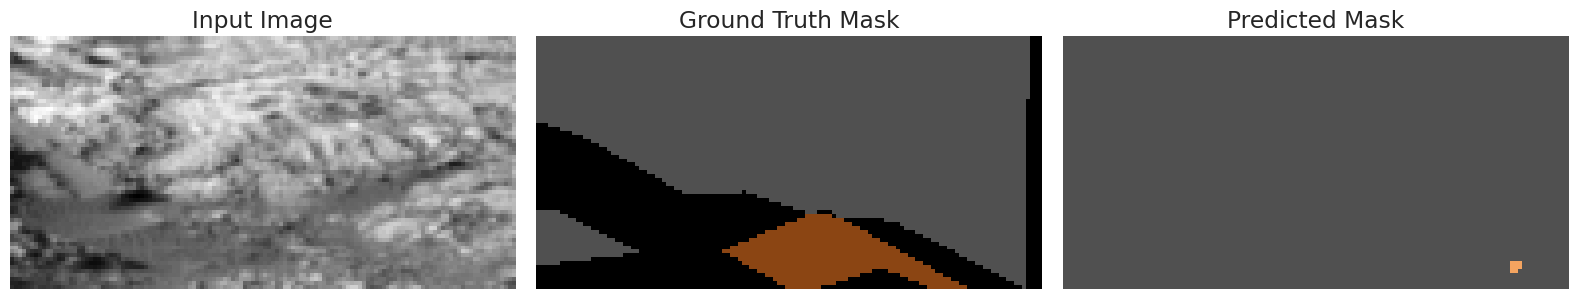

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 411ms/step - accuracy: 0.7136 - loss: 0.1751 - mean_iou: 0.8944 - val_accuracy: 0.6430 - val_loss: 0.3458 - val_mean_iou: 0.6154 - learning_rate: 0.0010
SCCE weight: 0.4512 - dice weight: 0.1952 - boundary weight: 0.3536
Epoch 87/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 389ms/step - accuracy: 0.7174 - loss: 0.1729 - mean_iou: 0.9055 - val_accuracy: 0.6715 - val_loss: 0.3240 - val_mean_iou: 0.6215 - learning_rate: 0.0010
SCCE weight: 0.4516 - dice weight: 0.1935 - boundary weight: 0.3549
Epoch 88/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 389ms/step - accuracy: 0.7259 - loss: 0.1622 - mean_iou: 0.9168 - val_accuracy: 0.6726 - val_loss: 0.3456 - val_mean_iou: 0.5956 - learning_rate: 0.0010
SCCE weight: 0.4521 - dice weight: 0.1917 - boundary weight: 0.3562
Epoch 89/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 389ms/step - accuracy: 0.7208 - loss: 0.1596 - mean_iou: 0.9175 - val_accuracy: 0.4336 - val_loss: 0.8534 - val_mean_iou: 0.3099 - learning_rate: 0.0010
SCCE weight: 0.4525 -

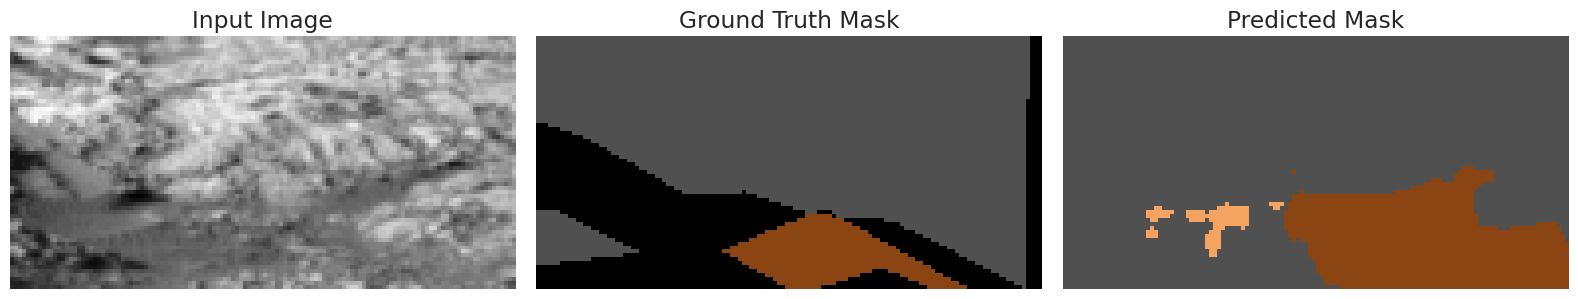

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.7199 - loss: 0.1571 - mean_iou: 0.9114 - val_accuracy: 0.5988 - val_loss: 0.4651 - val_mean_iou: 0.4818 - learning_rate: 0.0010
SCCE weight: 0.4534 - dice weight: 0.1865 - boundary weight: 0.3601
Epoch 92/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 389ms/step - accuracy: 0.7185 - loss: 0.1685 - mean_iou: 0.9085 - val_accuracy: 0.5829 - val_loss: 0.4828 - val_mean_iou: 0.4890 - learning_rate: 0.0010
SCCE weight: 0.4538 - dice weight: 0.1848 - boundary weight: 0.3614
Epoch 93/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 390ms/step - accuracy: 0.7212 - loss: 0.1578 - mean_iou: 0.9159 - val_accuracy: 0.6344 - val_loss: 0.4019 - val_mean_iou: 0.5486 - learning_rate: 0.0010
SCCE weight: 0.4542 - dice weight: 0.1831 - boundary weight: 0.3627
Epoch 94/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 391ms/step - accuracy: 0.7119 - loss: 0.1757 - mean_iou: 0.8825 - val_accuracy: 0.6105 - val_loss: 0.4673 - val_mean_iou: 0.5594 - learning_rate: 0.0010
SCCE weight: 0.4547 -

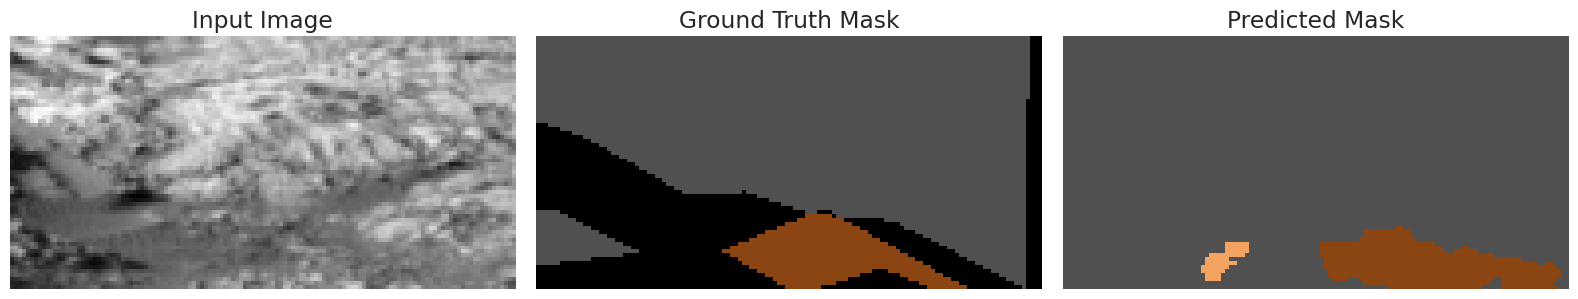

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 415ms/step - accuracy: 0.7229 - loss: 0.1467 - mean_iou: 0.9272 - val_accuracy: 0.6707 - val_loss: 0.3348 - val_mean_iou: 0.6611 - learning_rate: 1.0000e-04
SCCE weight: 0.4555 - dice weight: 0.1780 - boundary weight: 0.3665
Epoch 97/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.7283 - loss: 0.1494 - mean_iou: 0.9374 - val_accuracy: 0.6789 - val_loss: 0.3217 - val_mean_iou: 0.6654 - learning_rate: 1.0000e-04
SCCE weight: 0.4559 - dice weight: 0.1764 - boundary weight: 0.3677
Epoch 98/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.7312 - loss: 0.1548 - mean_iou: 0.9425 - val_accuracy: 0.6842 - val_loss: 0.3101 - val_mean_iou: 0.6736 - learning_rate: 1.0000e-04
SCCE weight: 0.4563 - dice weight: 0.1747 - boundary weight: 0.3690
Epoch 99/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.7328 - loss: 0.1463 - mean_iou: 0.9491 - val_accuracy: 0.6864 - val_loss: 0.3051 - val_mean_iou: 0.6790 - learning_rate: 1.0000e-04
SCCE 

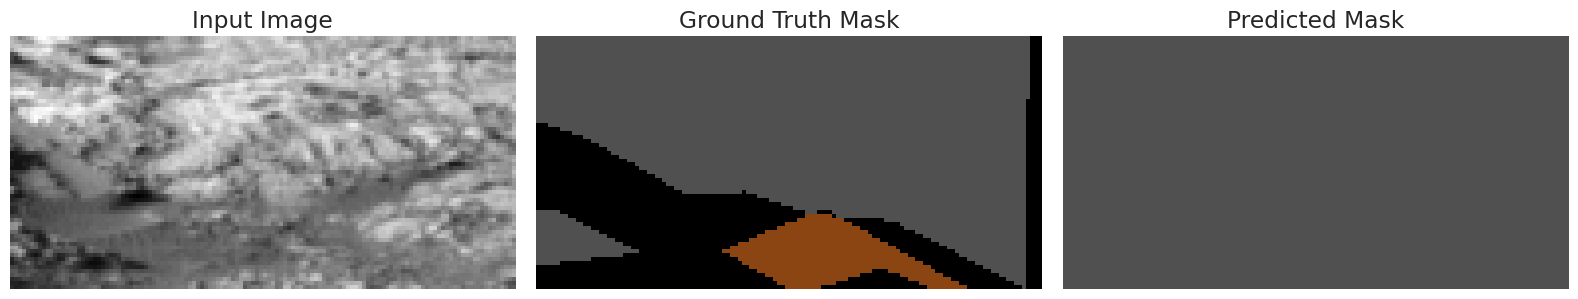

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 416ms/step - accuracy: 0.7344 - loss: 0.1469 - mean_iou: 0.9473 - val_accuracy: 0.6906 - val_loss: 0.3020 - val_mean_iou: 0.6685 - learning_rate: 1.0000e-04
SCCE weight: 0.4575 - dice weight: 0.1698 - boundary weight: 0.3726
Epoch 102/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - accuracy: 0.7345 - loss: 0.1426 - mean_iou: 0.9427 - val_accuracy: 0.6897 - val_loss: 0.3046 - val_mean_iou: 0.6618 - learning_rate: 1.0000e-04
SCCE weight: 0.4580 - dice weight: 0.1682 - boundary weight: 0.3739
Epoch 103/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - accuracy: 0.7312 - loss: 0.1394 - mean_iou: 0.9500 - val_accuracy: 0.6894 - val_loss: 0.3075 - val_mean_iou: 0.6541 - learning_rate: 1.0000e-04
SCCE weight: 0.4584 - dice weight: 0.1666 - boundary weight: 0.3751
Epoch 104/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - accuracy: 0.7311 - loss: 0.1408 - mean_iou: 0.9492 - val_accuracy: 0.6914 - val_loss: 0.3058 - val_mean_iou: 0.6528 - learning_rate: 1.0000e-04
SC

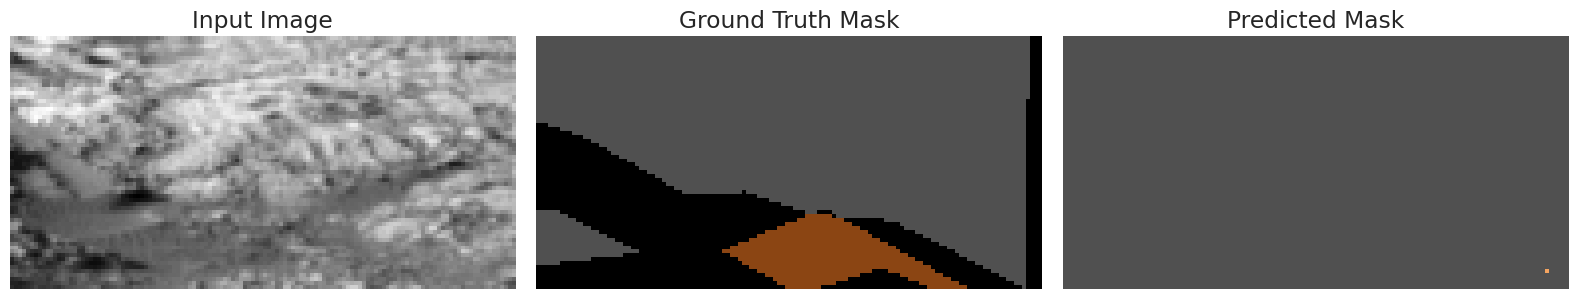

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 415ms/step - accuracy: 0.7362 - loss: 0.1425 - mean_iou: 0.9478 - val_accuracy: 0.6896 - val_loss: 0.3099 - val_mean_iou: 0.6481 - learning_rate: 1.0000e-04
SCCE weight: 0.4596 - dice weight: 0.1618 - boundary weight: 0.3787
Epoch 107/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.7337 - loss: 0.1426 - mean_iou: 0.9522 - val_accuracy: 0.6897 - val_loss: 0.3107 - val_mean_iou: 0.6477 - learning_rate: 1.0000e-04
SCCE weight: 0.4599 - dice weight: 0.1602 - boundary weight: 0.3798
Epoch 108/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.7332 - loss: 0.1366 - mean_iou: 0.9509 - val_accuracy: 0.6906 - val_loss: 0.3116 - val_mean_iou: 0.6402 - learning_rate: 1.0000e-04
SCCE weight: 0.4603 - dice weight: 0.1587 - boundary weight: 0.3810
Epoch 109/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.7342 - loss: 0.1403 - mean_iou: 0.9516 - val_accuracy: 0.6905 - val_loss: 0.3138 - val_mean_iou: 0.6372 - learning_rate: 1.0000e-04
SC

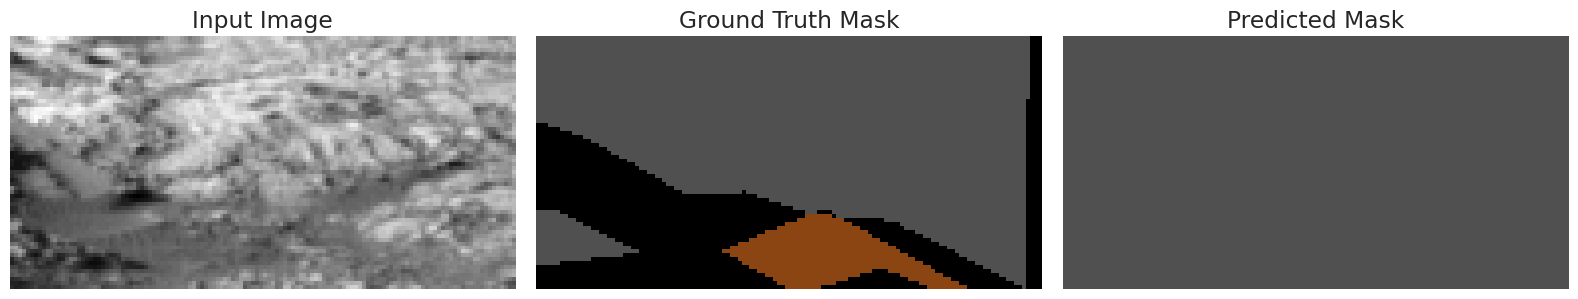

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 427ms/step - accuracy: 0.7343 - loss: 0.1319 - mean_iou: 0.9494 - val_accuracy: 0.6901 - val_loss: 0.3108 - val_mean_iou: 0.6434 - learning_rate: 1.0000e-04
SCCE weight: 0.4615 - dice weight: 0.1540 - boundary weight: 0.3845
Epoch 112/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7346 - loss: 0.1341 - mean_iou: 0.9505 - val_accuracy: 0.6884 - val_loss: 0.3172 - val_mean_iou: 0.6355 - learning_rate: 1.0000e-04
SCCE weight: 0.4619 - dice weight: 0.1525 - boundary weight: 0.3856
Epoch 113/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7344 - loss: 0.1342 - mean_iou: 0.9543 - val_accuracy: 0.6906 - val_loss: 0.3158 - val_mean_iou: 0.6328 - learning_rate: 1.0000e-04
SCCE weight: 0.4623 - dice weight: 0.1510 - boundary weight: 0.3868
Epoch 114/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.7337 - loss: 0.1269 - mean_iou: 0.9509 - val_accuracy: 0.6891 - val_loss: 0.3157 - val_mean_iou: 0.6398 - learning_rate: 1.0000e-04
SC

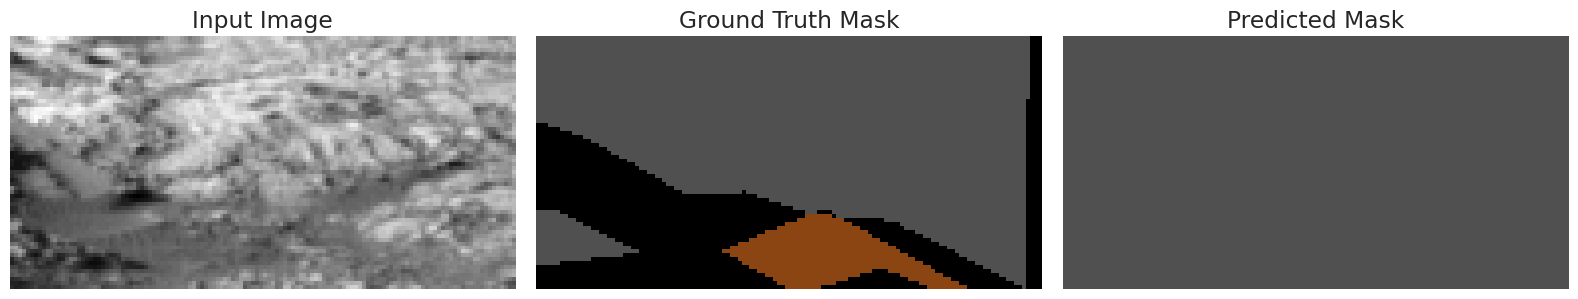

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 414ms/step - accuracy: 0.7337 - loss: 0.1319 - mean_iou: 0.9557 - val_accuracy: 0.6903 - val_loss: 0.3159 - val_mean_iou: 0.6402 - learning_rate: 1.0000e-04
SCCE weight: 0.4634 - dice weight: 0.1464 - boundary weight: 0.3902
Epoch 117/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7325 - loss: 0.1340 - mean_iou: 0.9564 - val_accuracy: 0.6892 - val_loss: 0.3180 - val_mean_iou: 0.6366 - learning_rate: 1.0000e-04
SCCE weight: 0.4638 - dice weight: 0.1450 - boundary weight: 0.3913
Epoch 118/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7322 - loss: 0.1350 - mean_iou: 0.9568 - val_accuracy: 0.6897 - val_loss: 0.3183 - val_mean_iou: 0.6368 - learning_rate: 1.0000e-04
SCCE weight: 0.4641 - dice weight: 0.1435 - boundary weight: 0.3924
Epoch 119/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7359 - loss: 0.1403 - mean_iou: 0.9569 - val_accuracy: 0.6900 - val_loss: 0.3165 - val_mean_iou: 0.6395 - learning_rate: 1.0000e-04
SC

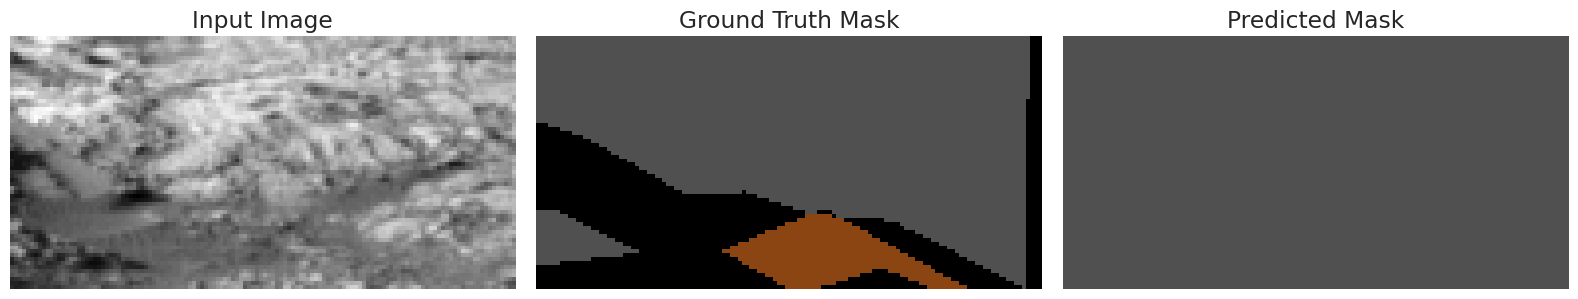

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - accuracy: 0.7314 - loss: 0.1350 - mean_iou: 0.9505 - val_accuracy: 0.6895 - val_loss: 0.3181 - val_mean_iou: 0.6424 - learning_rate: 1.0000e-04
SCCE weight: 0.4652 - dice weight: 0.1391 - boundary weight: 0.3957
Epoch 122/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7344 - loss: 0.1419 - mean_iou: 0.9564 - val_accuracy: 0.6906 - val_loss: 0.3164 - val_mean_iou: 0.6391 - learning_rate: 1.0000e-04
SCCE weight: 0.4656 - dice weight: 0.1376 - boundary weight: 0.3968
Epoch 123/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7352 - loss: 0.1316 - mean_iou: 0.9604 - val_accuracy: 0.6896 - val_loss: 0.3168 - val_mean_iou: 0.6440 - learning_rate: 1.0000e-04
SCCE weight: 0.4660 - dice weight: 0.1362 - boundary weight: 0.3979
Epoch 124/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.7406 - loss: 0.1422 - mean_iou: 0.9580 - val_accuracy: 0.6905 - val_loss: 0.3164 - val_mean_iou: 0.6428 - learning_rate: 1.0000e-04
SC

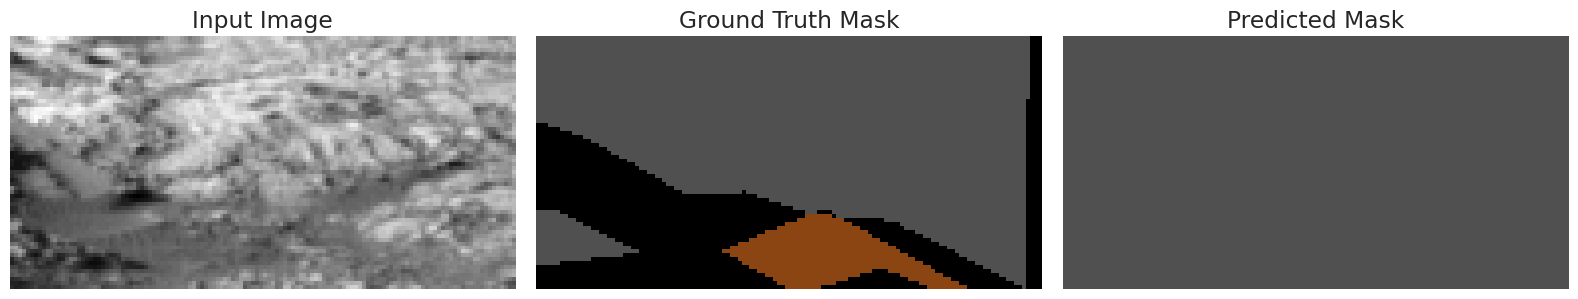

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - accuracy: 0.7338 - loss: 0.1356 - mean_iou: 0.9540 - val_accuracy: 0.6910 - val_loss: 0.3224 - val_mean_iou: 0.6435 - learning_rate: 1.0000e-04
SCCE weight: 0.4670 - dice weight: 0.1319 - boundary weight: 0.4011
Epoch 127/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.7385 - loss: 0.1311 - mean_iou: 0.9580 - val_accuracy: 0.6910 - val_loss: 0.3206 - val_mean_iou: 0.6394 - learning_rate: 1.0000e-04
SCCE weight: 0.4674 - dice weight: 0.1305 - boundary weight: 0.4021
Epoch 128/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.7382 - loss: 0.1359 - mean_iou: 0.9600 - val_accuracy: 0.6904 - val_loss: 0.3202 - val_mean_iou: 0.6409 - learning_rate: 1.0000e-04
SCCE weight: 0.4677 - dice weight: 0.1291 - boundary weight: 0.4032
Epoch 129/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7372 - loss: 0.1304 - mean_iou: 0.9570 - val_accuracy: 0.6902 - val_loss: 0.3195 - val_mean_iou: 0.6413 - learning_rate: 1.0000e-04
SC

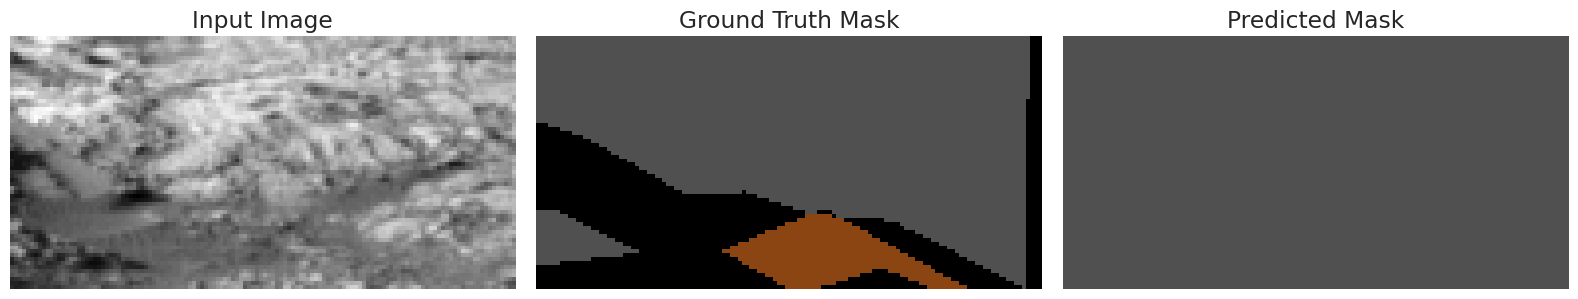

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 412ms/step - accuracy: 0.7312 - loss: 0.1315 - mean_iou: 0.9550 - val_accuracy: 0.6905 - val_loss: 0.3208 - val_mean_iou: 0.6395 - learning_rate: 1.0000e-04
SCCE weight: 0.4688 - dice weight: 0.1249 - boundary weight: 0.4063
Epoch 132/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.7316 - loss: 0.1343 - mean_iou: 0.9567 - val_accuracy: 0.6909 - val_loss: 0.3191 - val_mean_iou: 0.6399 - learning_rate: 1.0000e-04
SCCE weight: 0.4691 - dice weight: 0.1236 - boundary weight: 0.4073
Epoch 133/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.7352 - loss: 0.1372 - mean_iou: 0.9613 - val_accuracy: 0.6927 - val_loss: 0.3189 - val_mean_iou: 0.6342 - learning_rate: 1.0000e-04
SCCE weight: 0.4695 - dice weight: 0.1222 - boundary weight: 0.4084
Epoch 134/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 394ms/step - accuracy: 0.7343 - loss: 0.1306 - mean_iou: 0.9608 - val_accuracy: 0.6911 - val_loss: 0.3208 - val_mean_iou: 0.6326 - learning_rate: 1.0000e-04
SC

In [23]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, learning_rate, viz_callback, epoch_tracker],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

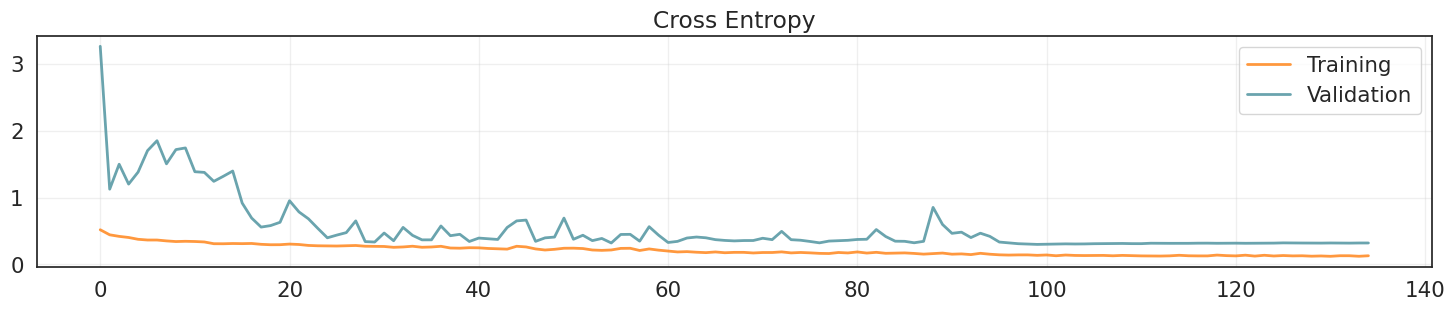

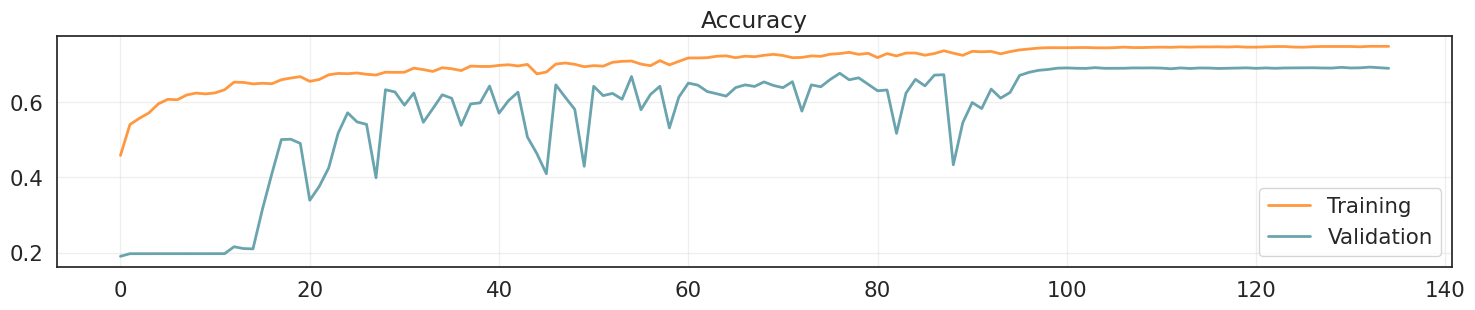

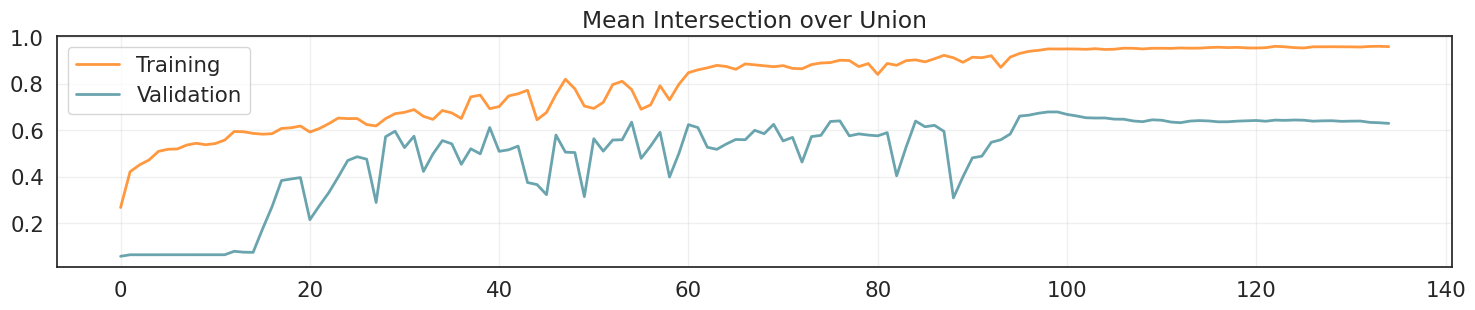

In [24]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🔮 Predictions on the Test Set

In [25]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [26]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from UNet_67.9.keras


In [27]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step
Predictions shape: (10022, 64, 128)


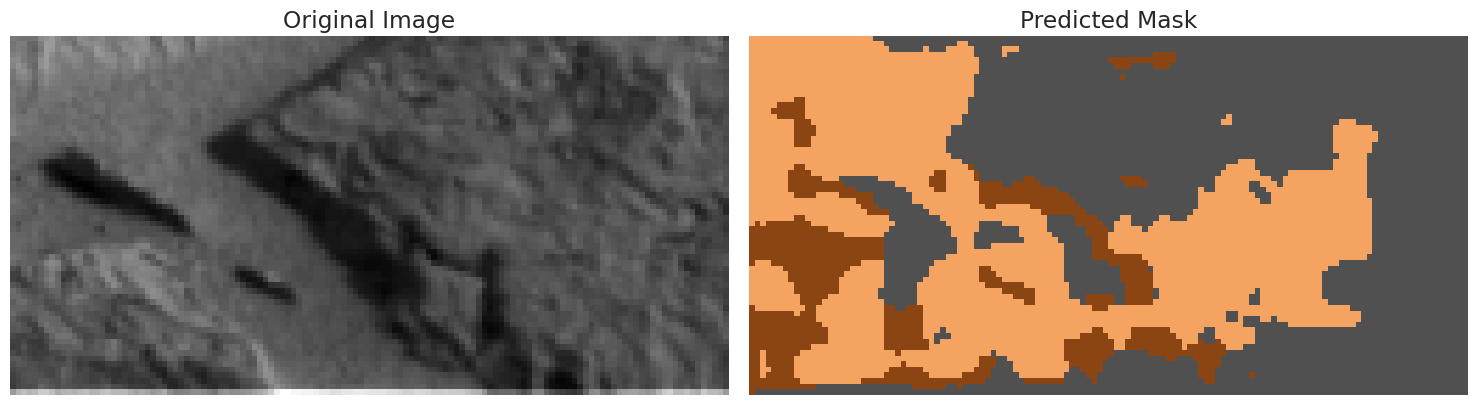

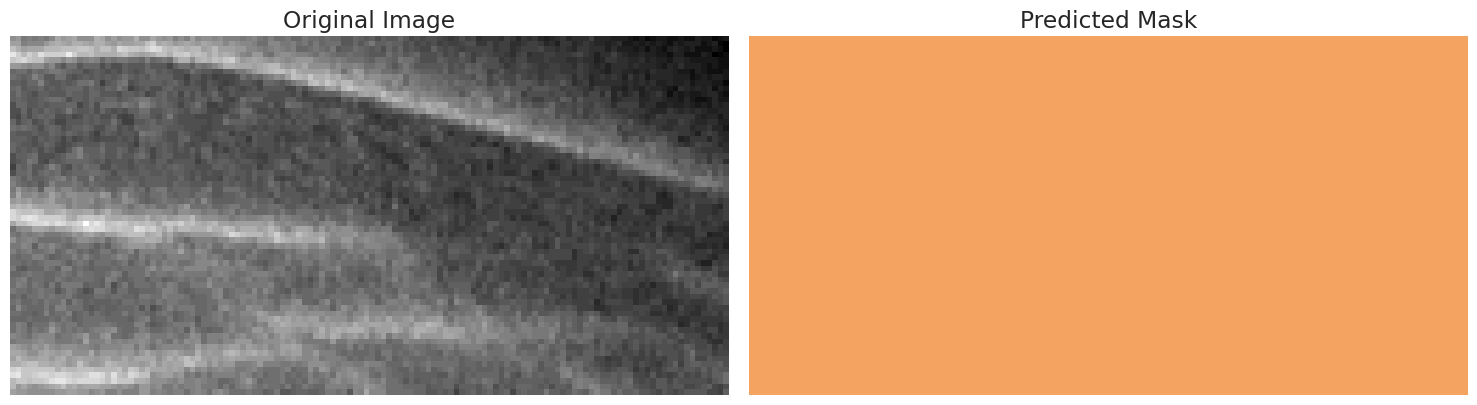

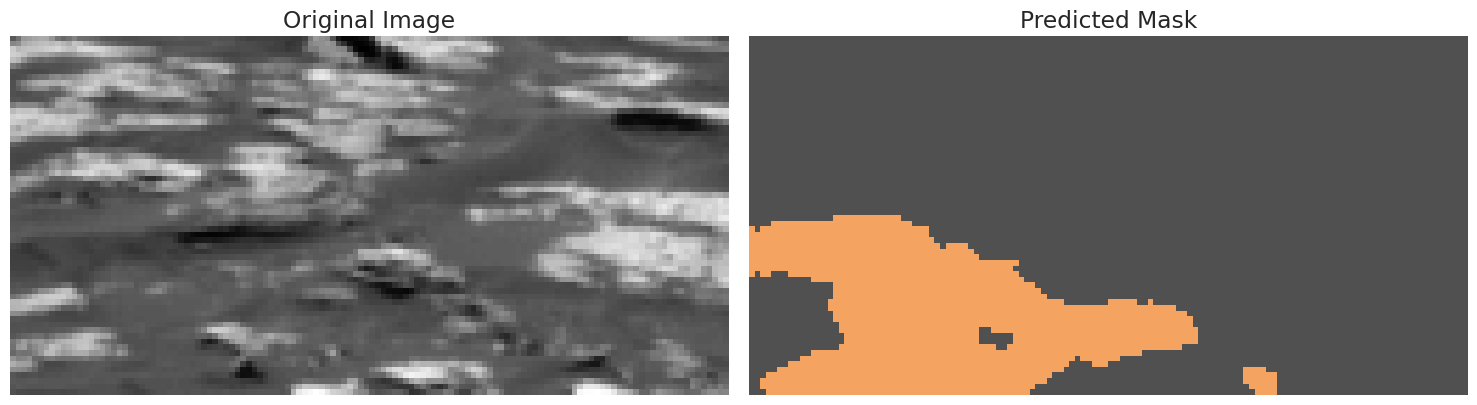

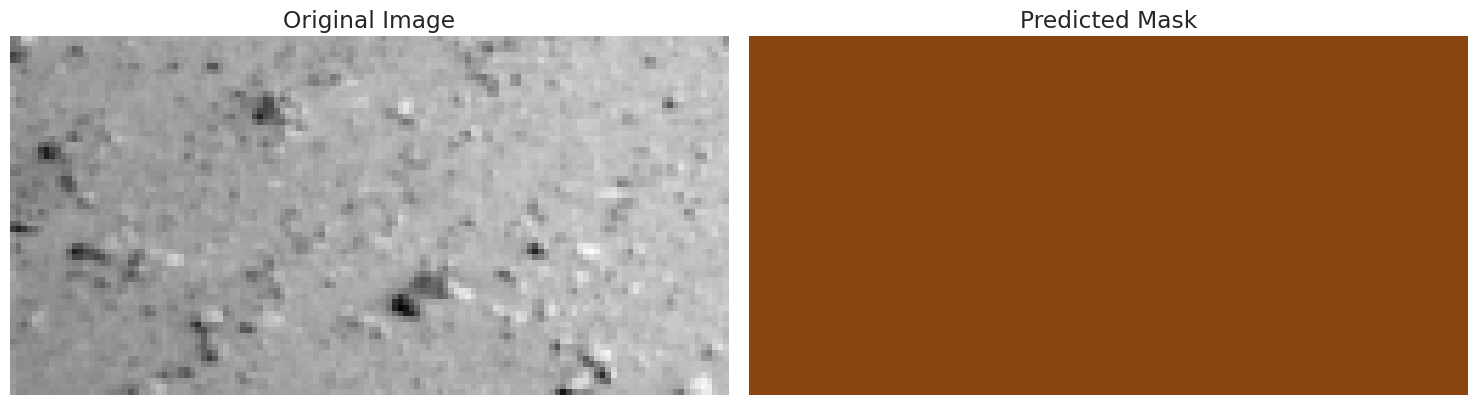

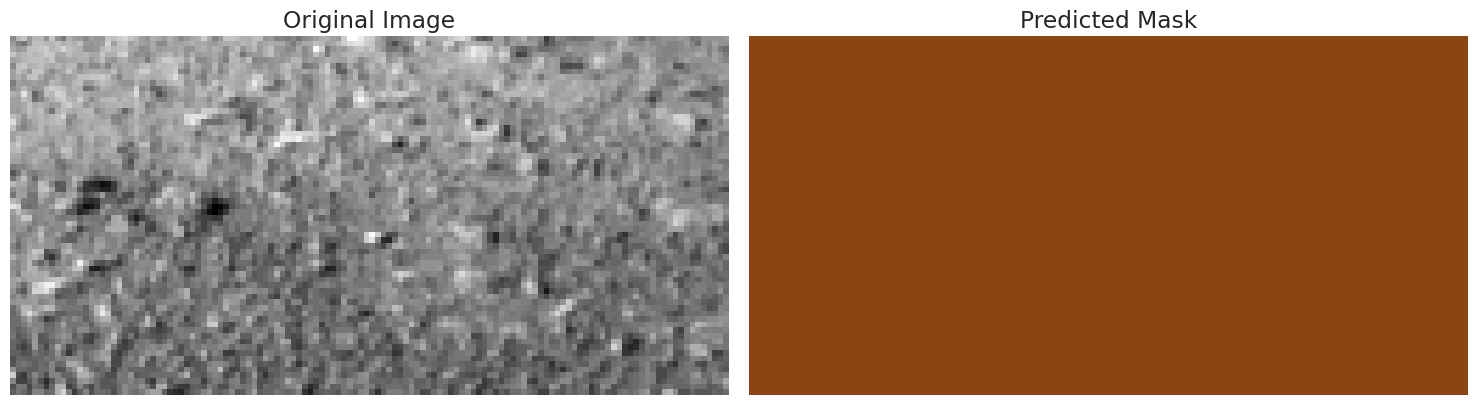

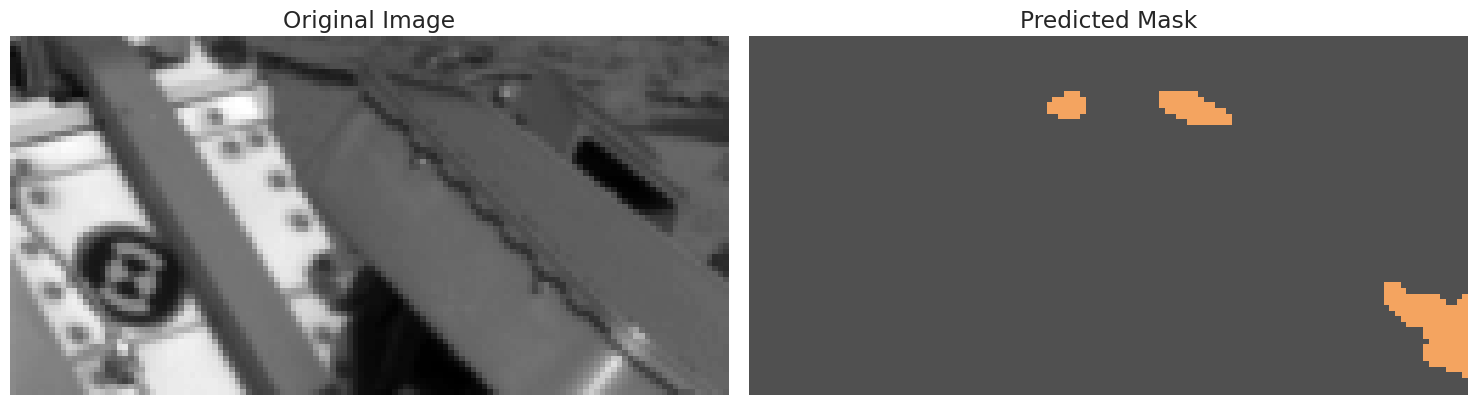

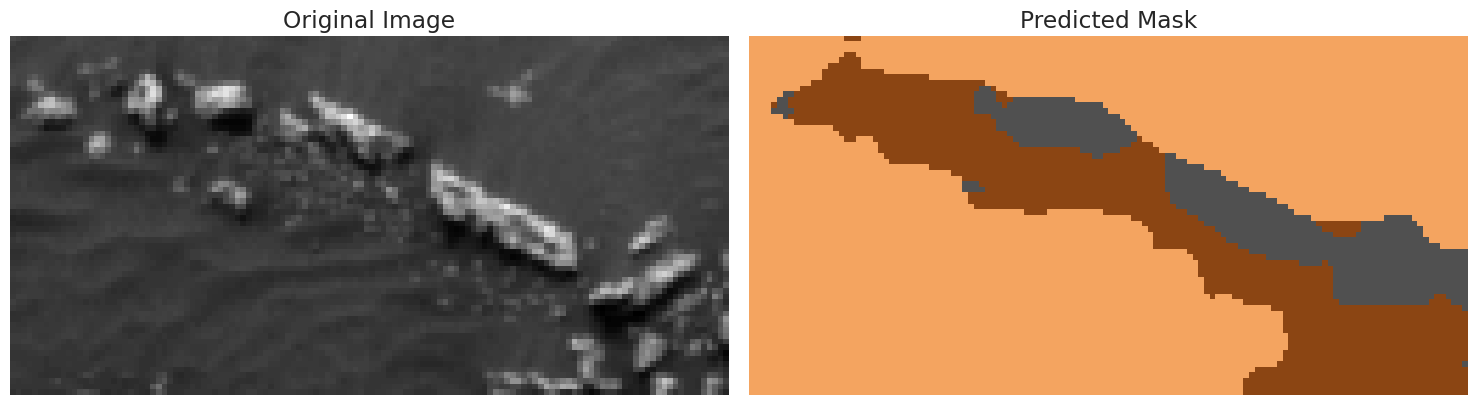

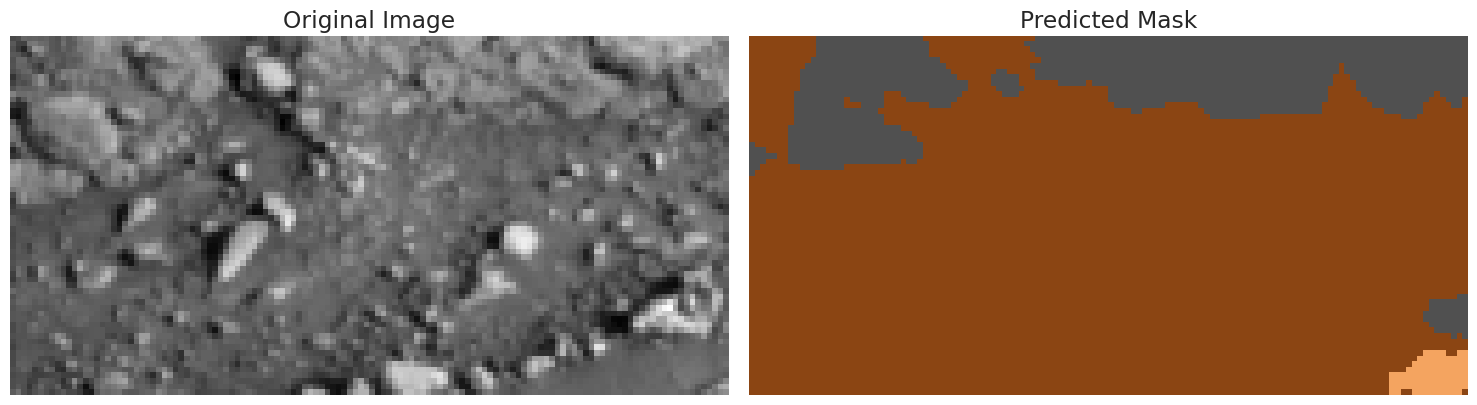

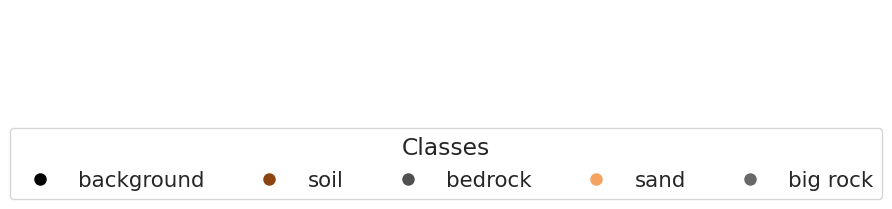

In [28]:
# Plot some predictions 
num_samples = 8
# Only take the first `num_samples` from X_test and preds
images = X_test[:num_samples]
predictions = preds[:num_samples]

# Adjust the number of classes to match the actual classes in the predictions (excluding 0)
num_classes = len(classes) # Excluding background

# Create colormap based on the number of classes
#colormap = create_segmentation_colormap(num_classes)

# Create a list to store the handles for the legend (only once)
handles = []

for i in range(num_samples):
    # Get the i-th image and its prediction
    image = images[i]
    predicted_mask = predictions[i]

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot original image
    axes[0].set_title("Original Image")
    axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].set_title("Predicted Mask")
    colored_pred = apply_colormap(predicted_mask, colormap)
    axes[1].imshow(colored_pred)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# After all images have been plotted, add the legend once
# We collect handles for the legend here, only once
for label_idx in category_map: 
    color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))

# Create a single legend displayed at the bottom
fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
ax.axis('off')
plt.show()

In [29]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [30]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)